In [29]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import xgcm
from xorca.lib import load_xorca_dataset
import pickle
import eddytools as et
from cmocean import cm
from dask.diagnostics import ProgressBar
import pandas as pd
import cartopy.crs as ccrs
from datetime import timedelta
import matplotlib.colors as colors

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
meshpath = ['/scratch/usr/shkifmjr/NUSERDATA/ORION/10-data/meshmask/1_mesh_mask.nc']

meshpath_x = ['/scratch/usr/shkmazel/masks/ORION10Xnospongeinocean/1_mesh_mask.nc']

datapath = '/scratch/usr/shkifmmp/master/data/ORION10/'
datapath_X = '/scratch/usr/shkifmmp/master/data/ORION10X/'

path_bathy = '/scratch/usr/shklvn09/SCRATCH/ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP05/OUT/'
path_bathy_x = '/scratch/usr/shkmazel/RESTARTS/ORION10Xnospongeinocean_RESTART/'

In [11]:
def interpolate(year, model): #modified for heatflux in ORION10
    YEAR = str(year)
    if model == 'ORION10':
        data_in = sorted(glob('/scratch/usr/shkifmmp/master/data/' + model + '/chunked/' +'1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP05_5d_' + YEAR + '0101_' + YEAR + '1231_grid_[TUV].nc'))
    
    # load data
        data = load_xorca_dataset(data_files=data_in, aux_files=meshpath, model_config='NEST',
                   input_ds_chunks = {"time_counter": 73, "t": 73,
                                      "z": 11, "deptht": 11, "depthu": 11, "depthv": 11, "depthw": 11,
                                      "x": 100, "y": 100},
                   target_ds_chunks = {"t": 73,
                                       "z_c": 11, "z_l": 11,
                                       "x_c": 100, "x_r": 100, "y_c": 100, "y_r": 100})
    
    elif model == 'ORION10X':
        data_in = sorted(glob('/scratch/usr/shkifmmp/master/data/' + model +  '/chunked/' +'1_FOCI2.0-TM041_5d_' + YEAR + '0101_' + YEAR + '1231_grid_[TUV].nc'))

        
    # load data
        data = load_xorca_dataset(data_files=data_in, aux_files=meshpath_x, model_config='NEST',
                   input_ds_chunks = {"time_counter": 73, "t": 73,
                                      "z": 11, "deptht": 11, "depthu": 11, "depthv": 11, "depthw": 11,
                                      "x": 100, "y": 100},
                   target_ds_chunks = {"t": 73,
                                       "z_c": 11, "z_l": 11,
                                       "x_c": 100, "x_r": 100, "y_c": 100, "y_r": 100})

    # define metrics for xgcm (not strictly necessary)
    at, au = data['e1t'] * data['e2t'], data['e1u'] * data['e2u']
    av, af = data['e1v'] * data['e2v'], data['e1f'] * data['e2f']
    vt, vu, vv, vw = data['e3t'] * at, data['e3u'] * au, data['e3v'] * av, data['e3w'] * at

    data = data.update({'at': at, 'au': au, 'av': av, 'af': af, 'vt': vt, 'vu': vu, 'vv': vv, 'vw': vw})
    data = data.set_coords(['at', 'au', 'av', 'af', 'vt', 'vu', 'vv', 'vw'])

    metrics = {
        ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
        ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
        ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'], # Z distances
        ('X', 'Y'): ['at', 'au', 'av', 'af'], # Areas
        ('X', 'Y', 'Z'): ['vt', 'vu', 'vv', 'vw'] # Volumes
    }

    metrics2D = {
        ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
        ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
        ('X', 'Y'): ['at', 'au', 'av', 'af'], # Areas
    }

    if model == 'ORION10':
        bathy = xr.open_dataset(path_bathy + '1_bathy_meter.nc')
        data = data.update({'bathymetry': (['y_c', 'x_c'], bathy['Bathymetry'].data)})
    elif model == 'ORION10X':
        bathy = xr.open_dataset(path_bathy_x + '1_bathy_meter.nc')
        data = data.update({'bathymetry': (['y_c', 'x_c'], bathy['Bathymetry'].data)})
        
    grid = xgcm.Grid(data, metrics=metrics)

    # Calculate vorticity and Okubo-Weiss parameter and make sure the chunk sizes are as before.
#     data_OW = et.okuboweiss.calc(data.isel(z_c=9, z_l=9), grid,
#                                  'vozocrtx', 'vomecrty').chunk({'x_c': 1002, 'x_r': 1002,
#                                                                 'y_c': 629, 'y_r': 629})

    # Merge the new variables `OW` and `vort` to the dataset `data`
#     data = xr.merge([data, data_OW], compat='override')

    # INTERPOLATION
    # Define the parameters for the interpolation -- CONSIDER THE DISOCNTINUITY IN THE LONGITUDE
    interpolation_parameters = {'model': 'ORCA',
                                'grid': 'latlon',
                                'start_time': YEAR + '-01-01', # time range start
                                'end_time': YEAR + '-12-31', # time range end
                                'calendar': 'standard', # calendar, must be either 360_day or standard
                                'lon1': 77.5, # minimum longitude of detection region
                                'lon2': 69.5,  # maximum longitude
                                'lat1': -65, # minimum latitude
                                'lat2': -37, # maximum latitude
                                'res': 1./10., # resolution of the fields in degrees
#                                 'vars_to_interpolate': ['OW', 'vort'], # variables to be interpolated 
                                'vars_to_interpolate': ['sohefldo'], # variables to be interpolated 
                                'mask_to_interpolate': ['fmask', 'tmask']}#,'bathymetry']} # masks to interpolate

    # The OW parameter and vorticity just need to be extracted at the depth level at which we want
    # to detect eddies. In this case we chose level 9
#     data_int_OW = et.interp.horizontal(data.isel(z_c=9, z_l=9), metrics2D, interpolation_parameters)
    
    #Interpolating heat flux - 2D
#     interpolation_parameters['vars_to_interpolate'] = ['sohefldo']
#     interpolation_parameters['mask_to_interpolate'] = ['fmask', 'tmask']

    data_int_heat = et.interp.horizontal(data, metrics2D, interpolation_parameters)

    # Now we change some of the parameters to interpolate other variables at all depths
    # Here we just use temperature and salinity
#     interpolation_parameters['vars_to_interpolate'] = ['votemper', 'vosaline']
#     interpolation_parameters['mask_to_interpolate'] = ['fmask', 'tmask']

    # Now we don't restrict the interpolation to one depth level
#     data_int = et.interp.horizontal(data, metrics, interpolation_parameters)

    # Load `OW` into memory so the `.rolling` operation is faster
#     OW_tmp = data_int_OW['OW'].compute()

     # Convert all land values to `NaN` so we don't have a lot of zeros when calculating
    # the standard deviation
#     OW_tmp = OW_tmp.where(OW_tmp != 0)
#     lon_tmp = OW_tmp['lon'].where(OW_tmp['lon'] > 0, other=OW_tmp['lon'] + 360.)
#     OW_tmp = OW_tmp.assign_coords({'lon': lon_tmp})

#     mean_OW_spatial_std = OW_tmp.rolling(
#                               lon=100, center=True, min_periods=1
#                               ).std(skipna=True).rolling(
#                               lat=100, center=True, min_periods=1
#                               ).std(skipna=True).mean('time')

    # Merge all interpolated datasets into on (override is necessary because some mask etc.
    # variables have been written to all datasets)
#     data_int = xr.merge([data_int, data_int_OW], 
#                        compat='override')#.chunk({'time': 1, 'lat': 100, 'lon': 100})
    
#     data_int = xr.merge([data_int, data_int_heat], 
#                        compat='override').chunk({'time': 1, 'lat': 100, 'lon': 100})

    # use if OW_std is 2D
#     data_int = data_int.update({'OW_std': (['lat', 'lon'], mean_OW_spatial_std.values)})

    data_int_heat = data_int_heat.chunk({'lon': 3561, 'lat': 501, 'z': 46})
#     with ProgressBar():
#         data_int.to_netcdf('/scratch/usr/shkifmmp/master/data/' + model + '/interpolated/' + 'int_data_75_71_y' + YEAR + '.nc')
        
    with ProgressBar():
        data_int_heat.to_netcdf('/scratch/usr/shkifmmp/master/data/' + model + '/interpolated/' + 'int_data_heat_y' + YEAR + '.nc')                  
    del data_int_heat, data#, lon_tmp, data_OW, data_int_OW, OW_tmp

In [13]:
for y in np.arange(1999,2018):
    interpolate(y, 'ORION10')

Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating sohefldo
Interpolating fmask
Interpolating tmask
Interpolating e1f
Interpolating e2f
[########################################] | 100% Completed | 36.1s
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating sohefldo
Interpolating fmask
Interpolating tmask
Interpolating e1f
Interpolating e2f
[########################################] | 100% Completed | 42.8s
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating sohefldo
Interpolating fmask
Interpolating tmask
Interpolating e1f
Interpolating e2f
[########################################] | 100% Completed | 31.3s
Interpolating from model grid: ORCA
No regridding necessary, just interpolating to vorticity grid point.
Interpolating sohefldo
Interpolating fmask
Interpolating tmask
Interpolating e1

In [ ]:
for y in np.arange(1970,2001):
    interpolate(y, 'ORION10X')

In [4]:
r_e = 6371 * 1e3
d_max = r_e * np.cos(np.pi * -50 / 180) * (np.pi/180) #CALCULATE LONGITUDE DISTANCE AT THIS LATITUDE
(d_max/10) #in meters - GET IN A 1/10 MODEL

47649.81407141733

In [117]:
data_int.sel(lat=slice(-40.09,-40)).e2f.values

array([[8514.65245558, 8514.65245558, 8514.65245558, ..., 8514.65245558,
        8514.65245558, 8514.65245558]])

In [112]:
(((7143.70426486 * 7143.70426486)/1e3) * 421)

21484686.97261094

In [121]:
(np.sqrt(((7143.70426486 * 7143.70426486) * 171) /np.pi) * 2) /1e3

105.40873024307079

In [5]:
del data_int

## LOAD DATA

In [98]:
data_int = xr.open_mfdataset(sorted(glob(datapath + 'interpolated/' + 'int_data_75*y197*'))[0])

In [99]:
data_int

<xarray.Dataset>
Dimensions:       (time: 73, z: 46, lat: 501, lon: 3561)
Coordinates:
  * time          (time) datetime64[ns] 1970-01-03T12:00:00 ... 1970-12-29T12...
  * z             (z) int64 1 2 3 4 5 6 7 8 9 10 ... 38 39 40 41 42 43 44 45 46
  * lat           (lat) float32 -65.97 -65.93 -65.89 ... -36.18 -36.09 -36.01
  * lon           (lon) float32 75.5 75.6 75.7 75.8 75.9 ... 71.2 71.3 71.4 71.5
Data variables:
    votemper      (time, z, lat, lon) float64 dask.array<chunksize=(73, 46, 501, 3561), meta=np.ndarray>
    vosaline      (time, z, lat, lon) float64 dask.array<chunksize=(73, 46, 501, 3561), meta=np.ndarray>
    fmask         (z, lat, lon) int8 dask.array<chunksize=(46, 501, 3561), meta=np.ndarray>
    tmask         (z, lat, lon) float64 dask.array<chunksize=(46, 501, 3561), meta=np.ndarray>
    e1f           (lat, lon) float64 dask.array<chunksize=(501, 3561), meta=np.ndarray>
    e2f           (lat, lon) float64 dask.array<chunksize=(501, 3561), meta=np.ndarray>
    OW            (time, lat, lon) float64 dask.array<chunksize=(73, 501, 3561), meta=np.ndarray>
    vort          (time, lat, lon) float64 dask.array<chunksize=(73, 501, 3561), meta=np.ndarray>
    bathymetry    (lat, lon) float64 dask.array<chunksize=(501, 3561), meta=np.ndarray>
    OW_std        (lat, lon) float64 dask.array<chunksize=(501, 3561), meta=np.ndarray>
    mask_regions  (lat, lon) float64 dask.array<chunksize=(501, 3561), meta=np.ndarray>
Attributes:
    history:                    Fri Nov 26 19:03:10 2021: /sw/dataformats/nco...
    history_of_appended_files:  Fri Nov 26 19:03:10 2021: Appended file int_m...
    NCO:                        netCDF Operators version 4.9.1 (Homepage = ht...

In [3]:
# For analysis of more years
data_int = xr.open_mfdataset(sorted(glob(datapath + 'interpolated/' + 'int_data_75*y200[1-5]*')))

In [6]:
data_int

<xarray.Dataset>
Dimensions:       (time: 365, z: 46, lat: 501, lon: 3561)
Coordinates:
  * time          (time) datetime64[ns] 2001-01-03T12:00:00 ... 2005-12-29T12...
  * z             (z) int64 1 2 3 4 5 6 7 8 9 10 ... 38 39 40 41 42 43 44 45 46
  * lat           (lat) float32 -65.97 -65.93 -65.89 ... -36.18 -36.09 -36.01
  * lon           (lon) float32 75.5 75.6 75.7 75.8 75.9 ... 71.2 71.3 71.4 71.5
Data variables:
    votemper      (time, z, lat, lon) float64 dask.array<chunksize=(73, 46, 501, 3561), meta=np.ndarray>
    vosaline      (time, z, lat, lon) float64 dask.array<chunksize=(73, 46, 501, 3561), meta=np.ndarray>
    fmask         (z, lat, lon) float64 dask.array<chunksize=(46, 501, 3561), meta=np.ndarray>
    tmask         (z, lat, lon) float64 dask.array<chunksize=(46, 501, 3561), meta=np.ndarray>
    e1f           (lat, lon) float64 dask.array<chunksize=(501, 3561), meta=np.ndarray>
    e2f           (lat, lon) float64 dask.array<chunksize=(501, 3561), meta=np.ndarray>
    OW            (time, lat, lon) float64 dask.array<chunksize=(73, 501, 3561), meta=np.ndarray>
    vort          (time, lat, lon) float64 dask.array<chunksize=(73, 501, 3561), meta=np.ndarray>
    bathymetry    (lat, lon) float64 dask.array<chunksize=(501, 3561), meta=np.ndarray>
    OW_std        (lat, lon) float64 dask.array<chunksize=(501, 3561), meta=np.ndarray>
    mask_regions  (time, lat, lon) float64 dask.array<chunksize=(73, 501, 3561), meta=np.ndarray>
    sohefldo      (time, lat, lon) float64 dask.array<chunksize=(73, 501, 3561), meta=np.ndarray>
Attributes:
    NCO:                        netCDF Operators version 4.9.1 (Homepage = ht...
    history:                    Tue Feb 22 12:54:07 2022: /sw/dataformats/nco...
    history_of_appended_files:  Tue Feb 22 12:54:07 2022: Appended file int_d...

In [4]:
# All these variables must be 2D
data_int['OW_std'] = data_int.OW_std.mean('time')
data_int['bathymetry'] = data_int.bathymetry.mean('time')
data_int['e1f'] = data_int.e1f.mean('time')
data_int['e2f'] = data_int.e2f.mean('time')
data_int['fmask'] = data_int.fmask.mean('time')
data_int['tmask'] = data_int.tmask.mean('time')

In [ ]:
# mask = data_int.mask_regions.copy()

# mask = mask.where(mask ==0, other =1)

# mask = mask.where(((mask == 1) & (mask.lon >= 15) & (mask.lon <= 45)) == False, other = 2) #region2

# mask = mask.where(((mask == 1) & (mask.lon >= 45) & (mask.lon <= 75)) == False, other = 3) #region 3

# mask = mask.where(((mask == 1) & (mask.lon >= 75) & (mask.lon <= 100)) == False, other = 4) #region 4

# mask = mask.where(((mask == 1) & (mask.lon >= 100) & (mask.lon <= 130)) == False, other = 5) #region 5

# mask = mask.where(((mask == 1) & (mask.lon >= 130) & (mask.lon <= 180)) == False, other = 6) #region 6

# mask = mask.where(((mask == 1) & (mask.lon >= -180) & (mask.lon <= -150)) == False, other = 7) #region 7

# mask = mask.where(((mask == 1) & (mask.lon >= -150) & (mask.lon <= -110)) == False, other = 8) #region 8

# mask = mask.where(((mask == 1) & (mask.lon >= -110) & (mask.lon <= -76)) == False, other = 9) #region 9

# mask = mask.where(((mask == 1) & (mask.lon >= -76) & (mask.lon <= -50)) == False, other = 10) #region 10

# mask = mask.where(((mask == 1) & (mask.lon >= -50) & (mask.lon <= -15)) == False, other = 11) #region 11

# data_int = data_int.update({'mask_regions_2': mask})

In [ ]:
# test mask
mask = data_int.mask_regions.copy()

mask = mask.isel(time=0).where(mask == 0, other=1)

OW_test = data_int.OW * mask

OW_std_test = data_int.OW_std * mask.mean('time')

vort_test = data_int.vort * mask

# data_int = data_int.update({'mask_regions_2': mask})
data_int = data_int.update({'OW_test': OW_test,
                           'OW_std_test': OW_std_test,
                           'vort_test': vort_test})

In [8]:
def pre_detection(model): #adicionar year_start
    
    if model == 'ORION10':
#         data_int = xr.open_mfdataset(sorted(glob(datapath + 'interpolated/' + 'int_data_75*y195[8-9]*') + glob(datapath + 'interpolated/' + 'int_data_75*y1960*')))
        data_int = xr.open_mfdataset(sorted(glob(datapath + 'interpolated/' + 'int_data_75*y199[89]*')) +
                                     sorted(glob(datapath + 'interpolated/' + 'int_data_75*y2*')))

    elif model == 'ORION10X':
        data_int = xr.open_mfdataset(sorted(glob(datapath + 'interpolated/' + 'int_data_75*y199[89]*')) +
                                     sorted(glob(datapath + 'interpolated/' + 'int_data_75*y2*')))
#         data_int = xr.open_mfdataset(sorted(glob(datapath_X + 'interpolated/' + 'int_data_75*y201[1-5]*')))
        
    data_int['OW_std'] = data_int.OW_std.mean('time')
    data_int['bathymetry'] = data_int.bathymetry.mean('time')
    data_int['e1f'] = data_int.e1f.mean('time')
    data_int['e2f'] = data_int.e2f.mean('time')
    data_int['fmask'] = data_int.fmask.mean('time')
    data_int['tmask'] = data_int.tmask.mean('time')
    
    mask_tmp = xr.open_mfdataset(sorted(glob(datapath + 'interpolated/' + 'int_data_75*y2000*'))).mask_regions
    
    mask = mask_tmp.copy()
    mask = mask.where(mask == 0, other=1)
    OW_test = data_int.OW * mask
    OW_std_test = data_int.OW_std * mask
    vort_test = data_int.vort * mask

# data_int = data_int.update({'mask_regions_2': mask})
    data_int = data_int.update({'OW_test': OW_test,
                               'OW_std_test': OW_std_test,
                               'vort_test': vort_test})
    return data_int

In [ ]:
# For analysis of more years
# data_vel = xr.open_mfdataset(sorted(glob(datapath + 'interpolated/' + 'int_data*y197[0-4]*_vel*')))

In [ ]:
del data_int

In [1]:
data_int

NameError: name 'data_int' is not defined

In [ ]:
data_int = pre_detection('ORION10')

In [2]:
data_int_2 = pre_detection('ORION10X')

NameError: name 'pre_detection' is not defined

In [ ]:
data_int

## DETECTION

Things to note for the setting of `detection_parameters`:  
1. `'lon1'` and `'lon2'` need to be in the range (-180, 180). `'lon2'` can be smaller than `'lon1'` if you want to extract work in a region extending across the dateline (e.g. `'lon1': 160`, `'lon2': -170`). 
2. `'OW_thr': data_int` if the field `OW_std` in `data_int` is 2D, i.e. we have a spatially varying standard deviation of the Okubo-Weiss parameter. `'OW_thr': data_int['OW_std'].values` if the field `OW_std` in `data_int` is 1D.  
3. `'OW_thr_factor'` is usually chosen in the range `(-0.5, -0.2)` ([Chelton et al., 2007](https://doi.org/10.1029/2007GL030812); [Isern-Fontanet et al., 2003](https://doi.org/10.1175/1520-0426(2003)20<772:IOMEFA>2.0.CO;2)).

In [ ]:
def detection_processing(model, time_start): #later add time periods
#     if region == 'region1': #atlantic
#         lon1 = -85
#         lon2 = 69.5
#     elif region == 'region2': 
#         lon1 = 77.5
#         lon2 = 145
#     elif region == 'region3':
#         lon1 = 145
#         lon2 = -85
        
#     if case == 7:
#         factor = 0.3
#         npix_max = 213
#     elif case == 9:
    time_i = str(time_start)
    time_e = str(time_start + 1)
    factor = 0.3
    npix_max = 421
    lon1= 77.5
    lon2= 69.5
#     elif case == 2:
#         factor = 0.5
#         npix_max = 213

    if model == 'ORION10':
        data_save = datapath
    elif model == 'ORION10X':
        data_save = datapath_X
    
    detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': time_i + '-01-01', # time range start
                        'end_time': time_e + '-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': lon1, # minimum longitude of detection region
                        'lon2': lon2, # maximum longitude
                        'lat1': -65, # minimum latitude
                        'lat2': -37, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': data_int, # 
                        'OW_thr_name': 'OW_std_test', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -factor, # Okubo-Weiss parameter threshold
                        'Npix_min': 10, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': npix_max} # maximum number of pixels (grid cells)
    
    if 'eddies' in globals():
        del globals()['eddies']
    
    with ProgressBar():
        globals()['eddies'] = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, ow_var = 'OW_test', vort_var = 'vort_test')
    
    # For every time step, we store one file on disk with all the information of the detected
    # eddies at this time step
    for i in np.arange(0, len(eddies)):
        datestring = str(eddies[i][0]['time'])[0:10]
        with open(data_save + 'eddies_detect/acc/case9_'
              + str(datestring) + '_eddies_OW' + str(factor) + '_' + str(lon1) + '_' + str(lon2) + '.pickle', 'wb') as f:
            pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
        f.close()
        
#     # Specify parameters for eddy tracking
#     tracking_parameters = {'model': 'ORCA',
#                            'grid': 'latlon',
#                            'start_time': time_i + '-01-03', # time range start
#                            'end_time': time_e + '-12-31', # time range end
#                            'calendar': 'standard', # calendar, must be either 360_day or standard
#                            'dt': 5, # temporal resolution of the data in days
#                            'lon1': lon1, # minimum longitude of detection region
#                            'lon2': lon2, # maximum longitudee
#                            'lat1': -65, # minimum latitude
#                            'lat2': -37, # maximum latitude
#                            'dE': 50., # maximum distance of search ellipsis from eddy center in towards the east 
#                                      # (if set to 0, it will be calculated as (150. / (7. / dt)))
#                            'eddy_scale_min': 0.5, # minimum factor by which eddy amplitude and area are allowed to change in one timestep
#                            'eddy_scale_max': 1.5, # maximum factor by which eddy amplitude and area are allowed to change in one timestep
#                            'dict': 0, # dictionary containing detected eddies to be used when not stored in files (set to 0 otherwise)
#                            'data_path': data_save + 'eddies_detect/acc/', # path to the detected eddies pickle files
#                            'file_root': 'case9',
#                            'file_spec': 'eddies_OW' + str(factor) + '_' + str(lon1) + '_' + str(lon2),
#                            'ross_path': '/scratch/usr/shkifmmp/master/data/'} # path to rossrad.dat containing Chelton et a1. 1998 Rossby radii
    
#     if 'tracks' in globals():
#         del globals()['tracks']
    
#     globals()['tracks'] = et.tracking.track(tracking_parameters, in_file=True)
    
#      # We save the tracks for later use
#     with open(data_save + '/eddies_detect/acc/'
#               + 'case9_' + time_i + '0101_' + time_e + '1231_tracks_OW' + str(factor)
#               + '_' + str(lon1) + '_' + str(lon2) + '.pickle', 'wb') as f:
#         pickle.dump(tracks, f, pickle.HIGHEST_PROTOCOL)
#     f.close()
    
#     return #detection_parameters, tracking_parameters

In [14]:
def tracking(model):
    if model == 'ORION10':
        data_save = datapath
    elif model == 'ORION10X':
        data_save = datapath_X
    # Specify parameters for eddy tracking
    tracking_parameters = {'model': 'ORCA',
                           'grid': 'latlon',
                           'start_time': '2001-01-03', # time range start
                           'end_time': '2001-12-31', # time range end
                           'calendar': 'standard', # calendar, must be either 360_day or standard
                           'dt': 5, # temporal resolution of the data in days
                           'lon1': 77.5, # minimum longitude of detection region
                           'lon2': 69.5, # maximum longitudee
                           'lat1': -65, # minimum latitude
                           'lat2': -37, # maximum latitude
                           'dE': 50., # maximum distance of search ellipsis from eddy center in towards the east 
                                     # (if set to 0, it will be calculated as (150. / (7. / dt)))
                           'eddy_scale_min': 0.5, # minimum factor by which eddy amplitude and area are allowed to change in one timestep
                           'eddy_scale_max': 1.5, # maximum factor by which eddy amplitude and area are allowed to change in one timestep
                           'dict': 0, # dictionary containing detected eddies to be used when not stored in files (set to 0 otherwise)
                           'data_path': data_save + 'eddies_detect/acc/', # path to the detected eddies pickle files
                           'file_root': 'case9',
                           'file_spec': 'eddies_OW0.3_77.5_69.5',
                           'ross_path': '/scratch/usr/shkifmmp/master/data/'} # path to rossrad.dat containing Chelton et a1. 1998 Rossby radii
    
    if 'tracks' in globals():
        del globals()['tracks']
    
    globals()['tracks'] = et.tracking.track(tracking_parameters, in_file=True)
    
     # We save the tracks for later use
    with open(data_save + '/eddies_detect/acc/'
              + 'case9_20010101_20011231_tracks_OW0.3_77.5_69.5.pickle', 'wb') as f:
        pickle.dump(tracks, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    
    #return #detection_parameters, tracking_parameters

In [ ]:
def open_eddies(region, case): #later update with model
    files_tmp = sorted(glob('/scratch/usr/shkifmmp/master/data/ORION10/eddies_detect/' + region + '/case' + str(case) + '/case' + str(case) + '_*_eddies_OW0.*.pickle'))
    eddies = {}
    for i in np.arange(0,len(files_tmp)):
        datestring = files_tmp[i][76:86]
        with open(datapath + 'eddies_detect/' + region + '/case' + str(case) + '/case' + str(case) + '_'
                  + str(datestring) + '_eddies_OW' + str(factor) + '_' + str(lon1) + '_' + str(lon2) + '.pickle', 'rb') as f:
            eddies.update({i: pickle.load(f)})
    return eddies

In [34]:
def create_eddy_stat(region): #needs lots of improvement
    
#     if 'eddy_stat' in globals():
#         del globals()['eddy_stat']
        
    if 'tracks' in globals():
        del globals()['tracks']
    
    if region == 'drake_passage':
        region_n = 'drake_passage'
        lon1= -76
        lon2= -50
        
    elif region == 'region_4':
        region_n= 'region_4_old'
        lon1= 77.5
        lon2= 100
        
#     if region == 'region1': #atlantic
#         lon1 = -85
#         lon2 = 69.5
#     elif region == 'region2': 
#         lon1 = 77.5
#         lon2 = 145
#     elif region == 'region3':
#         lon1 = 145
#         lon2 = -85
        
    with open(datapath + 'eddies_detect/' + region_n + '/case2/'
              + 'case2_19700101_19741231_tracks_OW0.5'
              + '_' + str(lon1) + '_' + str(lon2) + '.pickle', 'rb') as f:
        globals()['tracks'] = pickle.load(f)
    f.close()

    eddy_stat = pd.DataFrame.from_dict(tracks, orient = 'index').drop(['eddy_j', 'eddy_i'], axis=1)

    eddy_stat['case'] = 1

    #calculating the life_time
    for i in eddy_stat.index:
        eddy_stat.loc[i, 'life_time'] = pd.to_datetime(eddy_stat.time.iloc[i][-1]) - pd.to_datetime(eddy_stat.time.iloc[i][0])
        eddy_stat.loc[i, 'area_mean'] = eddy_stat.loc[i, 'area'].mean()
        eddy_stat.loc[i, 'area_max'] = eddy_stat.loc[i, 'area'].max()
        eddy_stat.loc[i, 'scale_mean'] = eddy_stat.loc[i, 'scale'].mean()
        eddy_stat.loc[i, 'scale_min'] = eddy_stat.loc[i, 'scale'].min()
        eddy_stat.loc[i, 'scale_max'] = eddy_stat.loc[i, 'scale'].max()  
    
    for c in [7, 8, 9]:
#     c = 9
        del globals()['tracks']
        if 'eddy_stat_aux' in locals():
            del eddy_stat_aux
            
#         thr = str(3)


        # This is how to open the tracks-file again (no need to do that if we just saved it)
        with open(datapath + 'eddies_detect/' + region_n + '/case'+ str(c) +'/'
                  + 'case' + str(c) + '_19700101_19741231_tracks_OW0.3'
                  + '_' + str(lon1) + '_' + str(lon2) + '.pickle', 'rb') as f:
            globals()['tracks'] = pickle.load(f)
        f.close()

        eddy_stat_aux = pd.DataFrame.from_dict(tracks, orient = 'index').drop(['eddy_j', 'eddy_i'], axis=1)

        eddy_stat_aux['case'] = (c - 5)

        #calculating the life_time
        for i in eddy_stat_aux.index:
            eddy_stat_aux.loc[i, 'life_time'] = pd.to_datetime(eddy_stat_aux.time.iloc[i][-1]) - pd.to_datetime(eddy_stat_aux.time.iloc[i][0])
            eddy_stat_aux.loc[i, 'area_mean'] = eddy_stat_aux.loc[i, 'area'].mean()
            eddy_stat_aux.loc[i, 'area_max'] = eddy_stat_aux.loc[i, 'area'].max()
            eddy_stat_aux.loc[i, 'scale_mean'] = eddy_stat_aux.loc[i, 'scale'].mean()
            eddy_stat_aux.loc[i, 'scale_min'] = eddy_stat_aux.loc[i, 'scale'].min()
            eddy_stat_aux.loc[i, 'scale_max'] = eddy_stat_aux.loc[i, 'scale'].max() 

        #adding case 2 to dataframe
        eddy_stat = eddy_stat.append(eddy_stat_aux)

        eddy_stat = eddy_stat.loc[(eddy_stat['exist_at_start'] ==  False) & (eddy_stat.terminated == True) 
                          & (eddy_stat.life_time >= timedelta(days=30))]
        
    return eddy_stat

In [35]:
eddy_stat_d = create_eddy_stat('drake_passage')

In [36]:
eddy_stat_r4 = create_eddy_stat('region_4')

In [126]:
eddy_stat_d.scale_mean.mean() * 2, eddy_stat.scale_mean.mean() * 2

(175.25637129455626, 168.1989175006734)

### ACC - ORION10

In [ ]:
%%time
detection_processing('ORION10', 2016)

In [15]:
tracking('ORION10')

tracking at time step  9  of  73
tracking at time step  17  of  73
tracking at time step  25  of  73
tracking at time step  33  of  73
tracking at time step  42  of  73
tracking at time step  50  of  73
tracking at time step  58  of  73
tracking at time step  66  of  73


In [8]:
tracks[0]

{'time': array(['1998-01-03T12:00:00.000000000', '1998-01-08T12:00:00.000000000',
        '1998-01-13T12:00:00.000000000'], dtype='datetime64[ns]'),
 'lon': array([-109.00164839, -108.61831903, -108.36886635]),
 'lat': array([-64.88503187, -64.90697139, -64.90771305]),
 'amp': array([3.30885660e-06, 3.27551202e-06, 1.82748219e-06]),
 'eddy_j': {0: array([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25,
         25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
         26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28,
         28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29]),
  1: array([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25,
         25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27,
         27, 27, 28, 28, 28, 28, 28]),
  2: array([24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27,
         27, 27, 28, 28, 28])},
 'eddy_i': {0: array([1749, 1750, 1751

### ORION10X

In [ ]:
%%time
detection_processing('ORION10X', 1986)

### SECTOR

#### REGION I

In [ ]:
%%time
detection_parameters1, tracking_parameters, datestring1 = detection_processing(9, 'region1')

#### REGION II

In [ ]:
%%time
detection_parameters2, tracking_parameters, datestring2 = detection_processing(9, 'region2')

#### REGION III

In [ ]:
%%time
detection_parameters3, tracking_parameters, datestring3 = detection_processing(9, 'region3')

In [ ]:
detect

In [ ]:
# Plot a single time step to see what the detection method detected
t=200
d_p = detection_parameters2
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(76.5,146)) #
# plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values) + 360) #for region 1 and 2, comment this line

plt.figure(figsize=(30,12))
map1 = plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(76.5,146)).OW.isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
               cmap=cm.balance, shading='auto')

plt.contour(plot_lon, data_int['lat'].values, mask.isel(time=0).sel(lon = slice(76.5,146)), colors= 'black')

for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] #+ 360 #for region 1 and 2, comment the '+ 360'
    else:
        eddy_lon = eddies[t][i]['lon']
    for s, c in zip([7, 6], ['k', 'gold']):
        plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(map1, pad=0.02, shrink=0.5)
c.ax.set_title('OW (s$^{-2}$)', loc='left', fontsize=16, y=1.04)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
# ax.xaxis.set_ticklabels([140, 160, 180, -160, -140, -120, -100, -80]) #for region 1 and 2, comment this line

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/regions/'
plt.savefig(save_path + 'detection_region2_t{}_case9.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
eddy_stat_1 = create_eddy_stat('region1')

In [ ]:
fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=3)

eddy_stat_1.groupby(eddy_stat_1.case).type.value_counts().unstack(1).plot.bar(ax=ax[0], color={'darkcyan', 'm'}, width=0.46)
ax[0].legend(['Anticyclone', 'Cyclone'], fontsize=12, loc='upper left')
ax[0].set_ylabel('Number of eddies', fontsize=16)
ax[0].tick_params(axis= 'y', labelsize= 14)
ax[0].tick_params(axis= 'x', labelsize= 14)
ax[0].set_ylim(bottom=2000, top=5500)

lim=ax[0].get_xlim()
eddy_stat_1.groupby(eddy_stat_1.case).life_time.max().astype('timedelta64[M]').plot.bar(ax=ax[1], position=1, width=0.23, color='midnightblue')
ax2 = ax[1].twinx()
eddy_stat_1.groupby(eddy_stat_1.case).life_time.mean().astype('timedelta64[D]').plot.bar(ax=ax2, color='darkred', rot=0, position=0, width=0.23)
ax[1].set_ylim(bottom=10, top=30)
ax2.set_xlim(lim)
ax2.set_ylim(bottom=50, top=80)
ax[1].set_ylabel('Max life time (months)', fontsize=16, color= 'midnightblue')
ax2.set_ylabel('Mean life time (days)', color='darkred', fontsize=16)
ax[1].tick_params(axis= 'y', labelcolor = 'midnightblue', labelsize= 14)
ax2.tick_params(axis= 'y', labelcolor = 'darkred', labelsize= 14)
ax[1].tick_params(axis= 'x', labelsize= 14)

(2* eddy_stat_1.groupby(eddy_stat_1.case).scale_mean.mean()).plot.bar(ax=ax[2], position=1, width=0.23, color='purple', label= 'Mean')
(2* eddy_stat_1.groupby(eddy_stat_1.case).scale_max.max()).plot.bar(ax=ax[2], position=0, width=0.23 ,color= 'k', label= 'Maximum')
ax[2].set_xlim(lim)
ax[2].set_ylabel('Diameter (km)', fontsize=16)
ax[2].tick_params(axis= 'y', labelsize= 14)
ax[2].tick_params(axis= 'x', labelsize= 14)
ax[2].set_ylim(bottom=40, top=190)

# eddy_stat.groupby(eddy_stat.index).life_time.mean().astype('timedelta64[D]').plot.bar(ax=ax, color='red', stacked='False')

ax[0].grid(axis='y')
ax[2].grid(axis='y')
ax2.grid()

ax[2].legend(loc='upper left', fontsize=12)

plt.suptitle('Region I', fontsize= 18)
plt.tight_layout()

for axs in ax:
    axs.set_xlabel('Case', fontsize=16)

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/regions/'
# plt.savefig(save_path + 'stats_r1.png', format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=3)

eddy_stat_2.groupby(eddy_stat_2.case).type.value_counts().unstack(1).plot.bar(ax=ax[0], color={'darkcyan', 'm'}, width=0.46)
ax[0].legend(['Anticyclone', 'Cyclone'], fontsize=12, loc='upper left')
ax[0].set_ylabel('Number of eddies', fontsize=16)
ax[0].tick_params(axis= 'y', labelsize= 14)
ax[0].tick_params(axis= 'x', labelsize= 14)
ax[0].set_ylim(bottom=2000, top=5500)

lim=ax[0].get_xlim()
eddy_stat_2.groupby(eddy_stat_2.case).life_time.max().astype('timedelta64[M]').plot.bar(ax=ax[1], position=1, width=0.23, color='midnightblue')
ax2 = ax[1].twinx()
eddy_stat_2.groupby(eddy_stat_2.case).life_time.mean().astype('timedelta64[D]').plot.bar(ax=ax2, color='darkred', rot=0, position=0, width=0.23)
ax[1].set_ylim(bottom=10, top=30)
ax2.set_xlim(lim)
ax2.set_ylim(bottom=50, top=80)
ax[1].set_ylabel('Max life time (months)', fontsize=16, color= 'midnightblue')
ax2.set_ylabel('Mean life time (days)', color='darkred', fontsize=16)
ax[1].tick_params(axis= 'y', labelcolor = 'midnightblue', labelsize= 14)
ax2.tick_params(axis= 'y', labelcolor = 'darkred', labelsize= 14)
ax[1].tick_params(axis= 'x', labelsize= 14)

(2* eddy_stat_2.groupby(eddy_stat_2.case).scale_mean.mean()).plot.bar(ax=ax[2], position=1, width=0.23, color='purple', label= 'Mean')
(2* eddy_stat_2.groupby(eddy_stat_2.case).scale_max.max()).plot.bar(ax=ax[2], position=0, width=0.23 ,color= 'k', label= 'Maximum')
ax[2].set_xlim(lim)
ax[2].set_ylabel('Diameter (km)', fontsize=16)
ax[2].tick_params(axis= 'y', labelsize= 14)
ax[2].tick_params(axis= 'x', labelsize= 14)
ax[2].set_ylim(bottom=40, top=190)

# eddy_stat.groupby(eddy_stat.index).life_time.mean().astype('timedelta64[D]').plot.bar(ax=ax, color='red', stacked='False')

ax[0].grid(axis='y')
ax[2].grid(axis='y')
ax2.grid()

ax[2].legend(loc='upper left', fontsize=12)

plt.suptitle('Region II', fontsize= 18)
plt.tight_layout()

for axs in ax:
    axs.set_xlabel('Case', fontsize=16)

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/regions/'
# plt.savefig(save_path + 'stats_r1.png', format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=3)

eddy_stat_3.groupby(eddy_stat_3.case).type.value_counts().unstack(1).plot.bar(ax=ax[0], color={'darkcyan', 'm'}, width=0.46)
ax[0].legend(['Anticyclone', 'Cyclone'], fontsize=12, loc='upper left')
ax[0].set_ylabel('Number of eddies', fontsize=16)
ax[0].tick_params(axis= 'y', labelsize= 14)
ax[0].tick_params(axis= 'x', labelsize= 14)
ax[0].set_ylim(bottom=2000, top=5500)

lim=ax[0].get_xlim()
eddy_stat_3.groupby(eddy_stat_3.case).life_time.max().astype('timedelta64[M]').plot.bar(ax=ax[1], position=1, width=0.23, color='midnightblue')
ax2 = ax[1].twinx()
eddy_stat_3.groupby(eddy_stat_3.case).life_time.mean().astype('timedelta64[D]').plot.bar(ax=ax2, color='darkred', rot=0, position=0, width=0.23)
ax[1].set_ylim(bottom=10, top=30)
ax2.set_xlim(lim)
ax2.set_ylim(bottom=50, top=80)
ax[1].set_ylabel('Max life time (months)', fontsize=16, color= 'midnightblue')
ax2.set_ylabel('Mean life time (days)', color='darkred', fontsize=16)
ax[1].tick_params(axis= 'y', labelcolor = 'midnightblue', labelsize= 14)
ax2.tick_params(axis= 'y', labelcolor = 'darkred', labelsize= 14)
ax[1].tick_params(axis= 'x', labelsize= 14)

(2* eddy_stat_3.groupby(eddy_stat_3.case).scale_mean.mean()).plot.bar(ax=ax[2], position=1, width=0.23, color='purple', label= 'Mean')
(2* eddy_stat_3.groupby(eddy_stat_3.case).scale_max.max()).plot.bar(ax=ax[2], position=0, width=0.23 ,color= 'k', label= 'Maximum')
ax[2].set_xlim(lim)
ax[2].set_ylabel('Diameter (km)', fontsize=16)
ax[2].tick_params(axis= 'y', labelsize= 14)
ax[2].tick_params(axis= 'x', labelsize= 14)
ax[2].set_ylim(bottom=40, top=190)

# eddy_stat.groupby(eddy_stat.index).life_time.mean().astype('timedelta64[D]').plot.bar(ax=ax, color='red', stacked='False')

ax[0].grid(axis='y')
ax[2].grid(axis='y')
ax2.grid()

ax[2].legend(loc='upper left', fontsize=12)

plt.suptitle('Region III', fontsize= 18)
plt.tight_layout()

for axs in ax:
    axs.set_xlabel('Case', fontsize=16)

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/regions/'
# plt.savefig(save_path + 'stats_r1.png', format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
eddy_stat_2 = create_eddy_stat('region2')

In [ ]:
eddy_stat_3 = create_eddy_stat('region3')

In [ ]:
eddy_stat_1.groupby(eddy_stat_1.case).scale_mean

In [ ]:
a

## Atlantic

### case 7

In [ ]:
# Specify parameters for eddy detection
detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': '1970-01-01', # time range start
                        'end_time': '1974-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': -95, # minimum longitude of detection region
                        'lon2': 17, # maximum longitude
                        'lat1': -65, # minimum latitude
                        'lat2': -37, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': data_int, # 
                        'OW_thr_name': 'OW_std_test', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -0.3, # Okubo-Weiss parameter threshold
                        'Npix_min': 10, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': 213} # maximum number of pixels (grid cells)

In [ ]:
# We detect eddies at level 10 [.isel(z=9)] (as we only calculated the Okubow-Weiss
# parameter at this level)
eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, ow_var = 'OW_test', vort_var = 'vort_test')

In [ ]:
# Plot a single time step to see what the detection method detected
t=30
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(-95,17)) #
# plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values - 360)

plt.figure(figsize=(26,15))
map1 = plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(-95,17)).OW.isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
               cmap=cm.balance, shading='auto')

plt.contour(plot_lon, data_int['lat'].values, mask.isel(time=0).sel(lon = slice(-95,17)), colors= 'black')

# for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
#     plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
#              [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
#              color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] #+ 360
    else:
        eddy_lon = eddies[t][i]['lon']
    for s, c in zip([7, 6], ['k', 'gold']):
        plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(map1, pad=0.02, shrink=0.5)
c.ax.set_title('OW (s$^{-2}$)', loc='left', fontsize=16, y=1.04)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
# ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
plt.savefig(save_path + 'detection_atlantic_t{}_case7.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
# For every time step, we store one file on disk with all the information of the detected
# eddies at this time step
for i in np.arange(0, len(eddies)):
    datestring = str(eddies[i][0]['time'])[0:10]
    with open(datapath + 'eddies_detect/atlantic/case7/' + 'case7_'
          + str(datestring) + '_eddies_OW0.3_-95_17.pickle', 'wb') as f:
        pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
    f.close()

In [ ]:
 # We save the tracks for later use
with open(datapath + '/eddies_detect/atlantic/case7/'
          + 'case7_19700101_19741231_tracks_OW0.3'
          + '_-95_17.pickle', 'wb') as f:
    pickle.dump(tracks, f, pickle.HIGHEST_PROTOCOL)
f.close()

### Atlantic

### case 9

In [ ]:
detection_processing(9, 'atlantic')

#### case 2

In [ ]:
%%time
detection_processing(2, 'atlantic')

In [ ]:
# Plot a single time step to see what the detection method detected
t=30
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(-95,17)) #
# plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values - 360)

plt.figure(figsize=(26,15))
map1 = plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(-95,17)).OW.isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
               cmap=cm.balance, shading='auto')

plt.contour(plot_lon, data_int['lat'].values, mask.isel(time=0).sel(lon = slice(-95,17)), colors= 'black')

# for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
#     plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
#              [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
#              color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] #+ 360
    else:
        eddy_lon = eddies[t][i]['lon']
    for s, c in zip([7, 6], ['k', 'gold']):
        plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(map1, pad=0.02, shrink=0.5)
c.ax.set_title('OW (s$^{-2}$)', loc='left', fontsize=16, y=1.04)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
# ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
plt.savefig(save_path + 'detection_atlantic_t{}_case2.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

### Pacific

#### case 7

In [ ]:
%%time
detection_processing(7, 'pacific')

In [ ]:
%%time
detection_parameters, tracking_parameters = detection_processing(9, 'pacific')

In [ ]:
%%time
detection_parameters, tracking_parameters = detection_processing(2, 'pacific')

In [ ]:
# Plot a single time step to see what the detection method detected
t=200
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(135,-95)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values + 360)

plt.figure(figsize=(26,15))
map1 = plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(135,-95)).OW.isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
               cmap=cm.balance, shading='auto')

plt.contour(plot_lon, data_int['lat'].values, mask.isel(time=0).sel(lon = slice(135,-95)), colors= 'black')

# for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
#     plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
#              [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
#              color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] + 360
    else:
        eddy_lon = eddies[t][i]['lon']
    for s, c in zip([7, 6], ['k', 'gold']):
        plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(map1, pad=0.02, shrink=0.5)
c.ax.set_title('OW (s$^{-2}$)', loc='left', fontsize=16, y=1.04)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
# ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/basins/'
plt.savefig(save_path + 'detection_pacific_t{}_case2.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

### eddy stats

In [ ]:
eddy_stat_at = create_eddy_stat('atlantic')

In [ ]:
eddy_stat_pa = create_eddy_stat('pacific')

### Bar plots

In [ ]:
fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=3)

eddy_stat_at.groupby(eddy_stat_at.case).type.value_counts().unstack(1).plot.bar(ax=ax[0], color={'darkcyan', 'm'}, width=0.46)
ax[0].legend(['Anticyclone', 'Cyclone'], fontsize=12, loc='upper left')
ax[0].set_ylabel('Number of eddies', fontsize=16)
ax[0].tick_params(axis= 'y', labelsize= 14)
ax[0].tick_params(axis= 'x', labelsize= 14)
ax[0].set_ylim(bottom=2000, top=5500)

lim=ax[0].get_xlim()
eddy_stat_at.groupby(eddy_stat_at.case).life_time.max().astype('timedelta64[M]').plot.bar(ax=ax[1], position=1, width=0.23, color='midnightblue')
ax2 = ax[1].twinx()
eddy_stat_at.groupby(eddy_stat_at.case).life_time.mean().astype('timedelta64[D]').plot.bar(ax=ax2, color='darkred', rot=0, position=0, width=0.23)
ax[1].set_ylim(bottom=10, top=25)
ax2.set_xlim(lim)
ax2.set_ylim(bottom=50, top=80)
ax[1].set_ylabel('Max life time (months)', fontsize=16, color= 'midnightblue')
ax2.set_ylabel('Mean life time (days)', color='darkred', fontsize=16)
ax[1].tick_params(axis= 'y', labelcolor = 'midnightblue', labelsize= 14)
ax2.tick_params(axis= 'y', labelcolor = 'darkred', labelsize= 14)
ax[1].tick_params(axis= 'x', labelsize= 14)

(2* eddy_stat_at.groupby(eddy_stat_at.case).scale_mean.mean()).plot.bar(ax=ax[2], position=1, width=0.23, color='purple', label= 'Mean')
(2* eddy_stat_at.groupby(eddy_stat_at.case).scale_max.max()).plot.bar(ax=ax[2], position=0, width=0.23 ,color= 'k', label= 'Maximum')
ax[2].set_xlim(lim)
ax[2].set_ylabel('Diameter (km)', fontsize=16)
ax[2].tick_params(axis= 'y', labelsize= 14)
ax[2].tick_params(axis= 'x', labelsize= 14)
ax[2].set_ylim(bottom=40, top=190)

# eddy_stat.groupby(eddy_stat.index).life_time.mean().astype('timedelta64[D]').plot.bar(ax=ax, color='red', stacked='False')

ax[0].grid(axis='y')
ax[2].grid(axis='y')
ax2.grid()

ax[2].legend(loc='upper left', fontsize=12)

plt.suptitle('Atlantic', fontsize= 18)
plt.tight_layout()

for axs in ax:
    axs.set_xlabel('Case', fontsize=16)

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/basins/'
plt.savefig(save_path + 'stats_atlantic.png', format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=3)

eddy_stat_pa.groupby(eddy_stat_pa.case).type.value_counts().unstack(1).plot.bar(ax=ax[0], color={'darkcyan', 'm'}, width=0.46)
ax[0].legend(['Anticyclone', 'Cyclone'], fontsize=12, loc='upper left')
ax[0].set_ylabel('Number of eddies', fontsize=16)
ax[0].tick_params(axis= 'y', labelsize= 14)
ax[0].tick_params(axis= 'x', labelsize= 14)
ax[0].set_ylim(bottom=2000, top=5500)

lim=ax[0].get_xlim()
eddy_stat_pa.groupby(eddy_stat_pa.case).life_time.max().astype('timedelta64[M]').plot.bar(ax=ax[1], position=1, width=0.23, color='midnightblue')
ax2 = ax[1].twinx()
eddy_stat_pa.groupby(eddy_stat_pa.case).life_time.mean().astype('timedelta64[D]').plot.bar(ax=ax2, color='darkred', rot=0, position=0, width=0.23)
ax[1].set_ylim(bottom=10, top=25)
ax2.set_xlim(lim)
ax2.set_ylim(bottom=50, top=80)
ax[1].set_ylabel('Max life time (months)', fontsize=16, color= 'midnightblue')
ax2.set_ylabel('Mean life time (days)', color='darkred', fontsize=16)
ax[1].tick_params(axis= 'y', labelcolor = 'midnightblue', labelsize= 14)
ax2.tick_params(axis= 'y', labelcolor = 'darkred', labelsize= 14)
ax[1].tick_params(axis= 'x', labelsize= 14)

(2* eddy_stat_pa.groupby(eddy_stat_pa.case).scale_mean.mean()).plot.bar(ax=ax[2], position=1, width=0.23, color='purple', label= 'Mean')
(2* eddy_stat_pa.groupby(eddy_stat_pa.case).scale_max.max()).plot.bar(ax=ax[2], position=0, width=0.23 ,color= 'k', label= 'Maximum')
ax[2].set_xlim(lim)
ax[2].set_ylabel('Diameter (km)', fontsize=16)
ax[2].tick_params(axis= 'y', labelsize= 14)
ax[2].tick_params(axis= 'x', labelsize= 14)
ax[2].set_ylim(bottom=40, top=180)

# eddy_stat.groupby(eddy_stat.index).life_time.mean().astype('timedelta64[D]').plot.bar(ax=ax, color='red', stacked='False')

ax[0].grid(axis='y')
ax[2].grid(axis='y')
ax2.grid()

ax[2].legend(loc='upper left', fontsize=12)

plt.suptitle('Pacific', fontsize= 18)
plt.tight_layout()

for axs in ax:
    axs.set_xlabel('Case', fontsize=16)

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/basins/'
plt.savefig(save_path + 'stats_pacific.png', format='png', facecolor="w",  bbox_inches='tight')

### DRAKE PASSAGE

### Case 2 n_min = 10, n_max=213,OW_thr = -0.5

In [ ]:
# Specify parameters for eddy detection
detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': '1970-01-01', # time range start
                        'end_time': '1974-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': -76, # minimum longitude of detection region
                        'lon2': -50, # maximum longitude
                        'lat1': -65, # minimum latitude
                        'lat2': -37, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': data_int, # 
                        'OW_thr_name': 'OW_std_test', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -0.5, # Okubo-Weiss parameter threshold
                        'Npix_min': 10, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': 213} # maximum number of pixels (grid cells)

In [ ]:
del eddies

In [ ]:
# We detect eddies at level 10 [.isel(z=9)] (as we only calculated the Okubow-Weiss
# parameter at this level)
eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, ow_var = 'OW_test', vort_var = 'vort_test')

In [ ]:
# Plot a single time step to see what the detection method detected
t=200
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(-77,-49)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values + 360)

plt.figure(figsize=(12,15))
plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(-77,-49)).OW.isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
               cmap=cm.balance, shading='auto')

for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] + 360
    else:
        eddy_lon = eddies[t][i]['lon']
    for s, c in zip([7, 6], ['k', 'gold']):
        plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(pad=0.02, shrink=0.5)
c.ax.set_title('OW (s$^{-2}$)', loc='left', fontsize=16, y=1.04)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
plt.savefig(save_path + 'detection_drake_t{}_case2_2.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
# For every time step, we store one file on disk with all the information of the detected
# eddies at this time step
for i in np.arange(0, len(eddies)):
    datestring = str(eddies[i][0]['time'])[0:10]
    with open(datapath + 'eddies_detect/drake_passage/case2/' + 'case2_'
          + str(datestring) + '_eddies_OW0.5_-76_-50.pickle', 'wb') as f:
        pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
    f.close()

In [ ]:
# Specify parameters for eddy tracking
tracking_parameters = {'model': 'ORCA',
                       'grid': 'latlon',
                       'start_time': '1970-01-03', # time range start
                       'end_time': '1974-12-31', # time range end
                       'calendar': 'standard', # calendar, must be either 360_day or standard
                       'dt': 5, # temporal resolution of the data in days
                       'lon1': -76, # minimum longitude of detection region
                       'lon2': -50, # maximum longitudee
                       'lat1': -65, # minimum latitude
                       'lat2': -37, # maximum latitude
                       'dE': 50., # maximum distance of search ellipsis from eddy center in towards the east 
                                 # (if set to 0, it will be calculated as (150. / (7. / dt)))
                       'eddy_scale_min': 0.5, # minimum factor by which eddy amplitude and area are allowed to change in one timestep
                       'eddy_scale_max': 1.5, # maximum factor by which eddy amplitude and area are allowed to change in one timestep
                       'dict': 0, # dictionary containing detected eddies to be used when not stored in files (set to 0 otherwise)
                       'data_path': datapath + 'eddies_detect/drake_passage/case2/', # path to the detected eddies pickle files
                       'file_root': 'case2',
                       'file_spec': 'eddies_OW0.5_-76_-50',
                       'ross_path': '/scratch/usr/shkifmmp/master/data/'} # path to rossrad.dat containing Chelton et a1. 1998 Rossby radii

In [ ]:
del tracks

In [ ]:
tracks = et.tracking.track(tracking_parameters, in_file=True)

In [ ]:
tracks

In [ ]:
# dataframe from dict

eddy_stat_aux = pd.DataFrame.from_dict(tracks, orient = 'index').drop(['eddy_j', 'eddy_i', 'scale', 'lon', 'lat', 'exist_at_start', 'terminated'], axis=1)

eddy_stat_aux['case'] = 2 

#calculating the life_time
for i in eddy_stat_aux.index:
    eddy_stat_aux.loc[i, 'life_time'] = pd.to_datetime(eddy_stat_aux.time.iloc[i][-1]) - pd.to_datetime(eddy_stat_aux.time.iloc[i][0])

#adding case 2 to dataframe
eddy_stat = eddy_stat.append(eddy_stat_aux)

In [ ]:
del eddy_stat_aux

In [ ]:
eddy_stat#.loc[eddy_stat['case'] == 4]

In [ ]:
# saving file
eddy_stat.to_pickle(path= datapath + 'eddies_detect/drake_passage/eddy_stat.pkl')

In [ ]:
 # We save the tracks for later use
with open(datapath + '/eddies_detect/drake_passage/case2/'
          + 'case2_19700101_19741231_tracks_OW0.5'
          + '_-76_-50.pickle', 'wb') as f:
    pickle.dump(tracks, f, pickle.HIGHEST_PROTOCOL)
f.close()

### Case 6 Npix_min: 10, Npix_max: 171 (800 km) OW_thr: -0.5

In [ ]:
# plot_lon = data_int['lon'].sel(lon = slice(-77,-49)) #
# plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values + 360)

# plt.figure(figsize=(12,15))
# plt.pcolormesh(plot_lon, data_int['lat'].values, OW_test.sel(lon = slice(-77,-49)).isel(time=209).values,
#                vmin=-3e-10, vmax=3e-10, 
#                cmap=cm.balance, shading='auto')

In [ ]:
# Specify parameters for eddy detection
detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': '1970-01-01', # time range start
                        'end_time': '1974-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': -76, # minimum longitude of detection region
                        'lon2': -50, # maximum longitude
                        'lat1': -65, # minimum latitude
                        'lat2': -37, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': data_int, # 
                        'OW_thr_name': 'OW_std_test', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -0.5, # Okubo-Weiss parameter threshold
                        'Npix_min': 10, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': 171} # maximum number of pixels (grid cells)

In [ ]:
del eddies

In [ ]:
# We detect eddies at level 10 [.isel(z=9)] (as we only calculated the Okubow-Weiss
# parameter at this level)
eddies = et.detection.detect_OW(data_int.isel(z=9) , detection_parameters, ow_var = 'OW_test', vort_var = 'vort_test')

In [ ]:
# Plot a single time step to see what the detection method detected
t=30
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(-77,-49)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values + 360)

plt.figure(figsize=(12,15))
plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(-77,-49)).OW.isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
               cmap=cm.balance, shading='auto')

for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] + 360
    else:
        eddy_lon = eddies[t][i]['lon']
    for s, c in zip([7, 6], ['k', 'gold']):
        plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(pad=0.02, shrink=0.5)
c.ax.set_title('OW (s$^{-2}$)', loc='left', fontsize=16, y=1.04)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
plt.savefig(save_path + '/detection_drake_t{}_case6_2_f.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
# For every time step, we store one file on disk with all the information of the detected
# eddies at this time step
for i in np.arange(0, len(eddies)):
    datestring = str(eddies[i][0]['time'])[0:10]
    with open(datapath + 'eddies_detect/drake_passage/case6/' + 'case6_'
          + str(datestring) + '_eddies_OW0.5_-76_-50.pickle', 'wb') as f:
        pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
    f.close()

In [ ]:
# Specify parameters for eddy tracking
tracking_parameters = {'model': 'ORCA',
                       'grid': 'latlon',
                       'start_time': '1970-01-03', # time range start
                       'end_time': '1974-12-31', # time range end
                       'calendar': 'standard', # calendar, must be either 360_day or standard
                       'dt': 5, # temporal resolution of the data in days
                       'lon1': -76, # minimum longitude of detection region
                       'lon2': -50, # maximum longitudee
                       'lat1': -65, # minimum latitude
                       'lat2': -37, # maximum latitude
                       'dE': 50., # maximum distance of search ellipsis from eddy center in towards the east 
                                 # (if set to 0, it will be calculated as (150. / (7. / dt)))
                       'eddy_scale_min': 0.5, # minimum factor by which eddy amplitude and area are allowed to change in one timestep
                       'eddy_scale_max': 1.5, # maximum factor by which eddy amplitude and area are allowed to change in one timestep
                       'dict': 0, # dictionary containing detected eddies to be used when not stored in files (set to 0 otherwise)
                       'data_path': datapath + 'eddies_detect/drake_passage/case6/', # path to the detected eddies pickle files
                       'file_root': 'case6',
                       'file_spec': 'eddies_OW0.5_-76_-50',
                       'ross_path': '/scratch/usr/shkifmmp/master/data/'} # path to rossrad.dat containing Chelton et a1. 1998 Rossby radii

In [ ]:
tracks = et.tracking.track(tracking_parameters, in_file=True)

In [ ]:
 # We save the tracks for later use
with open(datapath + '/eddies_detect/drake_passage/case6/'
          + 'case6_19700101_19741231_tracks_OW0.5'
          + '_-76_-50.pickle', 'wb') as f:
    pickle.dump(tracks, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [ ]:
# dataframe from dict

eddy_stat_aux = pd.DataFrame.from_dict(tracks, orient = 'index').drop(['eddy_j', 'eddy_i', 'scale', 'lon', 'lat', 'exist_at_start', 'terminated'], axis=1)

eddy_stat_aux['case'] = 6 

#calculating the life_time
for i in eddy_stat_aux.index:
    eddy_stat_aux.loc[i, 'life_time'] = pd.to_datetime(eddy_stat_aux.time.iloc[i][-1]) - pd.to_datetime(eddy_stat_aux.time.iloc[i][0])

In [ ]:
#adding case 2 to dataframe
eddy_stat = eddy_stat.append(eddy_stat_aux)

In [ ]:
# saving file
eddy_stat.to_pickle(path= datapath + 'eddies_detect/drake_passage/eddy_stat.pkl')

### Case 7 OW_thr=-0.3; Npix_min= 10; Npix_max=213 (1000km)

In [ ]:
# Specify parameters for eddy detection
detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': '1970-01-01', # time range start
                        'end_time': '1974-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': -76, # minimum longitude of detection region
                        'lon2': -50, # maximum longitude
                        'lat1': -65, # minimum latitude
                        'lat2': -37, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': data_int, # 
                        'OW_thr_name': 'OW_std_test', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -0.3, # Okubo-Weiss parameter threshold
                        'Npix_min': 10, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': 213} # maximum number of pixels (grid cells)

In [ ]:
del eddies

In [ ]:
# We detect eddies at level 10 [.isel(z=9)] (as we only calculated the Okubow-Weiss
# parameter at this level)
eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, ow_var = 'OW_test', vort_var = 'vort_test')

In [ ]:
plt.pcolormesh(data_int.mask_regions_2.where(data_int.mask_regions_2 == 10).isel(time=0).sel(lon = slice(-77,-49)))
plt.colorbar()

In [ ]:
# Plot a single time step to see what the detection method detected
t=30
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(-77,-49)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values + 360)

plt.figure(figsize=(12,15))
plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(-77,-49)).OW.isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
               cmap=cm.balance, shading='auto')

for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] + 360
    else:
        eddy_lon = eddies[t][i]['lon']
    for s, c in zip([7, 6], ['k', 'gold']):
        plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(pad=0.02, shrink=0.5)
c.ax.set_title('OW (s$^{-2}$)', loc='left', fontsize=16, y=1.04)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures//sensitivity/applied_mask/'
plt.savefig(save_path + 'detection_drake_t{}_case7_2.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
data_int.isel(time=200)

In [ ]:
# Plot a single time step to see what the detection method detected
t=30
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(-77,-49)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values + 360)

plt.figure(figsize=(12,15))

# plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(-77,-49)).OW.isel(time=t).values,
#                vmin=-3e-10, vmax=3e-10, 
#                cmap=cm.balance, shading='auto')

plt.pcolormesh(plot_lon, data_int['lat'].values, (tot_vel_30.sel(lon = slice(-77,-49)).values * 100),
               norm = colors.LogNorm(vmin=1e0, vmax= 50),
               cmap='jet', shading='auto')

for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] + 360
    else:
        eddy_lon = eddies[t][i]['lon']
    for s, c in zip([7, 6], ['k', 'gold']):
        plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(pad=0.02, shrink=0.5)
c.ax.set_title('U (cm$\,$s$^{-1}$)', loc='left', fontsize=16)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
plt.savefig(save_path + 'detection_drake_t{}_case7_2_U.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
# For every time step, we store one file on disk with all the information of the detected
# eddies at this time step
for i in np.arange(0, len(eddies)):
    datestring = str(eddies[i][0]['time'])[0:10]
    with open(datapath + 'eddies_detect/drake_passage/case7/' + 'case7_'
          + str(datestring) + '_eddies_OW0.3_-76_-50.pickle', 'wb') as f:
        pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
    f.close()

In [ ]:
# Specify parameters for eddy tracking
tracking_parameters = {'model': 'ORCA',
                       'grid': 'latlon',
                       'start_time': '1970-01-03', # time range start
                       'end_time': '1974-12-31', # time range end
                       'calendar': 'standard', # calendar, must be either 360_day or standard
                       'dt': 5, # temporal resolution of the data in days
                       'lon1': -76, # minimum longitude of detection region
                       'lon2': -50, # maximum longitudee
                       'lat1': -65, # minimum latitude
                       'lat2': -37, # maximum latitude
                       'dE': 50., # maximum distance of search ellipsis from eddy center in towards the east 
                                 # (if set to 0, it will be calculated as (150. / (7. / dt)))
                       'eddy_scale_min': 0.5, # minimum factor by which eddy amplitude and area are allowed to change in one timestep
                       'eddy_scale_max': 1.5, # maximum factor by which eddy amplitude and area are allowed to change in one timestep
                       'dict': 0, # dictionary containing detected eddies to be used when not stored in files (set to 0 otherwise)
                       'data_path': datapath + 'eddies_detect/drake_passage/case7/', # path to the detected eddies pickle files
                       'file_root': 'case7',
                       'file_spec': 'eddies_OW0.3_-76_-50',
                       'ross_path': '/scratch/usr/shkifmmp/master/data/'} # path to rossrad.dat containing Chelton et a1. 1998 Rossby radii

In [ ]:
tracks = et.tracking.track(tracking_parameters, in_file=True)

In [ ]:
 # We save the tracks for later use
with open(datapath + '/eddies_detect/drake_passage/case7/'
          + 'case7_19700101_19741231_tracks_OW0.3'
          + '_-76_-50.pickle', 'wb') as f:
    pickle.dump(tracks, f, pickle.HIGHEST_PROTOCOL)
f.close()

### Case 8 OW_thr=-0.3; Npix_min=10, Npix_max= 171 (800km)

In [ ]:
# Specify parameters for eddy detection
detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': '1970-01-01', # time range start
                        'end_time': '1974-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': -76, # minimum longitude of detection region
                        'lon2': -50, # maximum longitude
                        'lat1': -65, # minimum latitude
                        'lat2': -37, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': data_int, # 
                        'OW_thr_name': 'OW_std_test', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -0.3, # Okubo-Weiss parameter threshold
                        'Npix_min': 10, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': 171} # maximum number of pixels (grid cells)

In [ ]:
# We detect eddies at level 10 [.isel(z=9)] (as we only calculated the Okubow-Weiss
# parameter at this level)
eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, ow_var = 'OW_test', vort_var = 'vort_test')

In [ ]:
# Plot a single time step to see what the detection method detected
t=200
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(-77,-49)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values + 360)

# plt.figure(figsize=(12,15))

plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(-77,-49)).OW.isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
               cmap=cm.balance, shading='auto')

for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] + 360
    else:
        eddy_lon = eddies[t][i]['lon']
    for s, c in zip([7, 6], ['k', 'gold']):
        plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(pad=0.02, shrink=0.5)
c.ax.set_title('OW (s$^{-2}$)', loc='left', fontsize=16, y=1.04)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
# plt.savefig(save_path + 'detection_drake_t{}_case8_2.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
# For every time step, we store one file on disk with all the information of the detected
# eddies at this time step
for i in np.arange(0, len(eddies)):
    datestring = str(eddies[i][0]['time'])[0:10]
    with open(datapath + 'eddies_detect/drake_passage/case8/' + 'case8_'
          + str(datestring) + '_eddies_OW0.3_-76_-50.pickle', 'wb') as f:
        pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
    f.close()

In [ ]:
# Specify parameters for eddy tracking
tracking_parameters = {'model': 'ORCA',
                       'grid': 'latlon',
                       'start_time': '1970-01-03', # time range start
                       'end_time': '1974-12-31', # time range end
                       'calendar': 'standard', # calendar, must be either 360_day or standard
                       'dt': 5, # temporal resolution of the data in days
                       'lon1': -76, # minimum longitude of detection region
                       'lon2': -50, # maximum longitudee
                       'lat1': -65, # minimum latitude
                       'lat2': -37, # maximum latitude
                       'dE': 50., # maximum distance of search ellipsis from eddy center in towards the east 
                                 # (if set to 0, it will be calculated as (150. / (7. / dt)))
                       'eddy_scale_min': 0.5, # minimum factor by which eddy amplitude and area are allowed to change in one timestep
                       'eddy_scale_max': 1.5, # maximum factor by which eddy amplitude and area are allowed to change in one timestep
                       'dict': 0, # dictionary containing detected eddies to be used when not stored in files (set to 0 otherwise)
                       'data_path': datapath + 'eddies_detect/drake_passage/case8/', # path to the detected eddies pickle files
                       'file_root': 'case8',
                       'file_spec': 'eddies_OW0.3_-76_-50',
                       'ross_path': '/scratch/usr/shkifmmp/master/data/'} # path to rossrad.dat containing Chelton et a1. 1998 Rossby radii

In [ ]:
tracks = et.tracking.track(tracking_parameters, in_file=True)

In [ ]:
 # We save the tracks for later use
with open(datapath + '/eddies_detect/drake_passage/case8/'
          + 'case8_19700101_19741231_tracks_OW0.3'
          + '_-76_-50.pickle', 'wb') as f:
    pickle.dump(tracks, f, pickle.HIGHEST_PROTOCOL)
f.close()

### Case9 Npix_max = 43 (200km)

In [ ]:
# Specify parameters for eddy detection
detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': '1970-01-01', # time range start
                        'end_time': '1974-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': -76, # minimum longitude of detection region
                        'lon2': -50, # maximum longitude
                        'lat1': -65, # minimum latitude
                        'lat2': -37, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': data_int, # 
                        'OW_thr_name': 'OW_std_test', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -0.3, # Okubo-Weiss parameter threshold
                        'Npix_min': 10, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': 421} # maximum number of pixels (grid cells)

In [ ]:
del eddies

In [ ]:
# We detect eddies at level 10 [.isel(z=9)] (as we only calculated the Okubow-Weiss
# parameter at this level)
eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, ow_var = 'OW_test', vort_var = 'vort_test')

In [ ]:
# Plot a single time step to see what the detection method detected
t=30
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(-77,-49)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values + 360)

plt.figure(figsize=(12,15))

plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(-77,-49)).OW.isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
               cmap=cm.balance, shading='auto')

for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] + 360
    else:
        eddy_lon = eddies[t][i]['lon']
    for s, c in zip([7, 6], ['k', 'gold']):
        plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(pad=0.02, shrink=0.5)
c.ax.set_title('OW (s$^{-2}$)', loc='left', fontsize=16, y=1.04)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
# plt.savefig(save_path + 'detection_drake_t{}_case9_2.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
# Plot a single time step to see what the detection method detected
t=200
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(-77,-49)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values + 360)

plt.figure(figsize=(12,15))

# plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(-77,-49)).OW.isel(time=t).values,
#                vmin=-3e-10, vmax=3e-10, 
#                cmap=cm.balance, shading='auto')

plt.pcolormesh(plot_lon, data_int['lat'].values, (tot_vel_200.sel(lon = slice(-77,-49)).values * 100),
               norm = colors.LogNorm(vmin=1e0, vmax= 50),
               cmap='jet', shading='auto')

for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] + 360
    else:
        eddy_lon = eddies[t][i]['lon']
    for s, c in zip([7, 6], ['k', 'gold']):
        plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(pad=0.02, shrink=0.5)
c.ax.set_title('U (cm$\,$s$^{-1}$)', loc='left', fontsize=16)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
# plt.savefig(save_path + 'detection_drake_t{}_case9_2_U.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
# For every time step, we store one file on disk with all the information of the detected
# eddies at this time step
for i in np.arange(0, len(eddies)):
    datestring = str(eddies[i][0]['time'])[0:10]
    with open(datapath + 'eddies_detect/drake_passage/case9/' + 'case9_'
          + str(datestring) + '_eddies_OW0.3_-76_-50.pickle', 'wb') as f:
        pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
    f.close()

In [ ]:
# Specify parameters for eddy tracking
tracking_parameters = {'model': 'ORCA',
                       'grid': 'latlon',
                       'start_time': '1970-01-03', # time range start
                       'end_time': '1974-12-31', # time range end
                       'calendar': 'standard', # calendar, must be either 360_day or standard
                       'dt': 5, # temporal resolution of the data in days
                       'lon1': -76, # minimum longitude of detection region
                       'lon2': -50, # maximum longitudee
                       'lat1': -65, # minimum latitude
                       'lat2': -37, # maximum latitude
                       'dE': 50., # maximum distance of search ellipsis from eddy center in towards the east 
                                 # (if set to 0, it will be calculated as (150. / (7. / dt)))
                       'eddy_scale_min': 0.5, # minimum factor by which eddy amplitude and area are allowed to change in one timestep
                       'eddy_scale_max': 1.5, # maximum factor by which eddy amplitude and area are allowed to change in one timestep
                       'dict': 0, # dictionary containing detected eddies to be used when not stored in files (set to 0 otherwise)
                       'data_path': datapath + 'eddies_detect/drake_passage/case9/', # path to the detected eddies pickle files
                       'file_root': 'case9',
                       'file_spec': 'eddies_OW0.3_-76_-50',
                       'ross_path': '/scratch/usr/shkifmmp/master/data/'} # path to rossrad.dat containing Chelton et a1. 1998 Rossby radii

In [ ]:
tracks = et.tracking.track(tracking_parameters, in_file=True)

In [ ]:
 # We save the tracks for later use
with open(datapath + '/eddies_detect/drake_passage/case9/'
          + 'case9_19700101_19741231_tracks_OW0.3'
          + '_-76_-50.pickle', 'wb') as f:
    pickle.dump(tracks, f, pickle.HIGHEST_PROTOCOL)
f.close()

## Region 4

lon: 75:100 --> starting from 77.5 because of the discontinuity in the data (from where it was possible to interpolate)

### Case 2 Npix_min=10; Npix_max=213; OW_thr=-0.5

In [ ]:
# Specify parameters for eddy detection
detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': '1970-01-01', # time range start
                        'end_time': '1974-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': 77.5, # minimum longitude of detection region
                        'lon2': 100, # maximum longitude
                        'lat1': -65, # minimum latitude
                        'lat2': -37, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': data_int, # 
                        'OW_thr_name': 'OW_std_test', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -0.5, # Okubo-Weiss parameter threshold
                        'Npix_min': 10, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': 213} # maximum number of pixels (grid cells)

In [ ]:
del eddies

In [ ]:
# We detect eddies at level 10 [.isel(z=9)] (as we only calculated the Okubow-Weiss
# parameter at this level)
eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, ow_var = 'OW_test', vort_var = 'vort_test')

In [ ]:
# Plot a single time step to see what the detection method detected
t=200
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(76.5,101)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values + 360)

plt.figure(figsize=(12,15))
plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(76.5,101)).OW.isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
               cmap=cm.balance, shading='auto')

for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] + 360
    else:
        eddy_lon = eddies[t][i]['lon']
    for s, c in zip([7, 6], ['k', 'gold']):
        plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(pad=0.02, shrink=0.5)
c.ax.set_title('OW (s$^{-2}$)', loc='left', fontsize=16, y=1.04)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
# ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
plt.savefig(save_path + 'detection_REGION4_t{}_case2_2.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
# For every time step, we store one file on disk with all the information of the detected
# eddies at this time step
for i in np.arange(0, len(eddies)):
    datestring = str(eddies[i][0]['time'])[0:10]
    with open(datapath + 'eddies_detect/region_4/case2/' + 'case2_'
          + str(datestring) + '_eddies_OW0.5_77.5_100.pickle', 'wb') as f:
        pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
    f.close()

In [ ]:
# Specify parameters for eddy tracking
tracking_parameters = {'model': 'ORCA',
                       'grid': 'latlon',
                       'start_time': '1970-01-03', # time range start
                       'end_time': '1974-12-31', # time range end
                       'calendar': 'standard', # calendar, must be either 360_day or standard
                       'dt': 5, # temporal resolution of the data in days
                       'lon1': 77.5, # minimum longitude of detection region
                       'lon2': 100, # maximum longitudee
                       'lat1': -65, # minimum latitude
                       'lat2': -37, # maximum latitude
                       'dE': 50., # maximum distance of search ellipsis from eddy center in towards the east 
                                 # (if set to 0, it will be calculated as (150. / (7. / dt)))
                       'eddy_scale_min': 0.5, # minimum factor by which eddy amplitude and area are allowed to change in one timestep
                       'eddy_scale_max': 1.5, # maximum factor by which eddy amplitude and area are allowed to change in one timestep
                       'dict': 0, # dictionary containing detected eddies to be used when not stored in files (set to 0 otherwise)
                       'data_path': datapath + 'eddies_detect/region_4/case2/', # path to the detected eddies pickle files
                       'file_root': 'case2',
                       'file_spec': 'eddies_OW0.5_77.5_100',
                       'ross_path': '/scratch/usr/shkifmmp/master/data/'} # path to rossrad.dat containing Chelton et a1. 1998 Rossby radii

In [ ]:
tracks = et.tracking.track(tracking_parameters, in_file=True)

In [ ]:
# dataframe from dict

eddy_stat = pd.DataFrame.from_dict(tracks, orient = 'index').drop(['eddy_j', 'eddy_i', 'scale', 'lon', 'lat', 'exist_at_start', 'terminated'], axis=1)

eddy_stat['case'] = 2 

for i in eddy_stat.index:
    eddy_stat.loc[i, 'life_time'] = pd.to_datetime(eddy_stat.time.iloc[i][-1]) - pd.to_datetime(eddy_stat.time.iloc[i][0])

In [ ]:
eddy_stat

In [ ]:
# saving file
eddy_stat.to_pickle(path= datapath + 'eddies_detect/region_4/eddy_stat.pkl')

In [ ]:
 # We save the tracks for later use
with open(datapath + '/eddies_detect/region_4/case2/'
          + 'case2_19700101_19741231_tracks_OW0.5'
          + '_77.5_100.pickle', 'wb') as f:
    pickle.dump(tracks, f, pickle.HIGHEST_PROTOCOL)
f.close()

### Case 6 Npix_min: 10; Npix_max: 171 (800km) ; OW_thr: -0.5

In [ ]:
200*1e3 / 4699.3

In [ ]:
4699.3 * 43

In [ ]:
# Specify parameters for eddy detection
detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': '1970-01-01', # time range start
                        'end_time': '1974-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': 77.5, # minimum longitude of detection region
                        'lon2': 100, # maximum longitude
                        'lat1': -65, # minimum latitude
                        'lat2': -37, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': data_int, # 
                        'OW_thr_name': 'OW_std_test', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -0.5, # Okubo-Weiss parameter threshold
                        'Npix_min': 10, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': 171} # maximum number of pixels (grid cells)

In [ ]:
del eddies

In [ ]:
# We detect eddies at level 10 [.isel(z=9)] (as we only calculated the Okubow-Weiss
# parameter at this level)
eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, ow_var = 'OW_test', vort_var = 'vort_test')

In [ ]:
# Plot a single time step to see what the detection method detected
t=200
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(76.5,101)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values + 360)

plt.figure(figsize=(12,15))
plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(76.5,101)).OW.isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
               cmap=cm.balance, shading='auto')

for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] + 360
    else:
        eddy_lon = eddies[t][i]['lon']
    for s, c in zip([7, 6], ['k', 'gold']):
        plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(pad=0.02, shrink=0.5)
c.ax.set_title('OW (s$^{-2}$)', loc='left', fontsize=16, y=1.04)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
# ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
plt.savefig(save_path + 'detection_REGION4_t{}_case6_2.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
# For every time step, we store one file on disk with all the information of the detected
# eddies at this time step
for i in np.arange(0, len(eddies)):
    datestring = str(eddies[i][0]['time'])[0:10]
    with open(datapath + 'eddies_detect/region_4/case6/' + 'case6_'
          + str(datestring) + '_eddies_OW0.5_77.5_100.pickle', 'wb') as f:
        pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
    f.close()

In [ ]:
# Specify parameters for eddy tracking
tracking_parameters = {'model': 'ORCA',
                       'grid': 'latlon',
                       'start_time': '1970-01-03', # time range start
                       'end_time': '1974-12-31', # time range end
                       'calendar': 'standard', # calendar, must be either 360_day or standard
                       'dt': 5, # temporal resolution of the data in days
                       'lon1': 77.5, # minimum longitude of detection region
                       'lon2': 100, # maximum longitudee
                       'lat1': -65, # minimum latitude
                       'lat2': -37, # maximum latitude
                       'dE': 50., # maximum distance of search ellipsis from eddy center in towards the east 
                                 # (if set to 0, it will be calculated as (150. / (7. / dt)))
                       'eddy_scale_min': 0.5, # minimum factor by which eddy amplitude and area are allowed to change in one timestep
                       'eddy_scale_max': 1.5, # maximum factor by which eddy amplitude and area are allowed to change in one timestep
                       'dict': 0, # dictionary containing detected eddies to be used when not stored in files (set to 0 otherwise)
                       'data_path': datapath + 'eddies_detect/region_4/case6/', # path to the detected eddies pickle files
                       'file_root': 'case6',
                       'file_spec': 'eddies_OW0.5_77.5_100',
                       'ross_path': '/scratch/usr/shkifmmp/master/data/'} # path to rossrad.dat containing Chelton et a1. 1998 Rossby radii

In [ ]:
tracks = et.tracking.track(tracking_parameters, in_file=True)

In [ ]:
 # We save the tracks for later use
with open(datapath + '/eddies_detect/region_4/case6/'
          + 'case6_19700101_19741231_tracks_OW0.5'
          + '_77.5_100.pickle', 'wb') as f:
    pickle.dump(tracks, f, pickle.HIGHEST_PROTOCOL)
f.close()

### Case 7 Npix_min=10; Npix_max= 213 (1000km); OW_thr= -0.3

In [ ]:
# Specify parameters for eddy detection
detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': '1970-01-01', # time range start
                        'end_time': '1974-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': 77.5, # minimum longitude of detection region
                        'lon2': 100, # maximum longitude
                        'lat1': -65, # minimum latitude
                        'lat2': -37, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': data_int, # 
                        'OW_thr_name': 'OW_std_test', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -0.3, # Okubo-Weiss parameter threshold
                        'Npix_min': 10, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': 213} # maximum number of pixels (grid cells)

In [ ]:
del eddies

In [ ]:
# We detect eddies at level 10 [.isel(z=9)] (as we only calculated the Okubow-Weiss
# parameter at this level)
eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, ow_var = 'OW_test', vort_var = 'vort_test')

In [ ]:
# Plot a single time step to see what the detection method detected
t=30
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(76.5,101)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values + 360)

plt.figure(figsize=(12,15))
plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(76.5,101)).OW.isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
               cmap=cm.balance, shading='auto')

for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] + 360
    else:
        eddy_lon = eddies[t][i]['lon']
    for s, c in zip([7, 6], ['k', 'gold']):
        plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(pad=0.02, shrink=0.5)
c.ax.set_title('OW (s$^{-2}$)', loc='left', fontsize=16, y=1.04)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
# ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
# plt.savefig(save_path + 'detection_REGION4_t{}_case7_2.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
# Plot a single time step to see what the detection method detected
t=200
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(76.5,101)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values + 360)

# plt.figure(figsize=(12,15))
# plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(76.5,101)).OW.isel(time=t).values,
#                vmin=-3e-10, vmax=3e-10, 
#                cmap=cm.balance, shading='auto')

plt.figure(figsize=(12,15))
plt.pcolormesh(plot_lon, data_int['lat'].values, (tot_vel_200.sel(lon = slice(76.5,101)).values * 100),
#                vmin=5e-3, vmax= 0.5,
#                vmax=1, 
               norm = colors.LogNorm(vmin=1e0, vmax= 50),
               cmap='jet', shading='auto')

for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] + 360
    else:
        eddy_lon = eddies[t][i]['lon']
    for s, c in zip([7, 6], ['k', 'gold']):
        plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(pad=0.02, shrink=0.5)
c.ax.set_title('U (cm$\,$s$^{-1}$)', loc='left', fontsize=16)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
# ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
plt.savefig(save_path + 'detection_REGION4_t{}_case7_2_mask_U.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
# For every time step, we store one file on disk with all the information of the detected
# eddies at this time step
for i in np.arange(0, len(eddies)):
    datestring = str(eddies[i][0]['time'])[0:10]
    with open(datapath + 'eddies_detect/region_4/case7/' + 'case7_'
          + str(datestring) + '_eddies_OW0.3_77.5_100.pickle', 'wb') as f:
        pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
    f.close()

In [ ]:
# Specify parameters for eddy tracking
tracking_parameters = {'model': 'ORCA',
                       'grid': 'latlon',
                       'start_time': '1970-01-03', # time range start
                       'end_time': '1974-12-31', # time range end
                       'calendar': 'standard', # calendar, must be either 360_day or standard
                       'dt': 5, # temporal resolution of the data in days
                       'lon1': 77.5, # minimum longitude of detection region
                       'lon2': 100, # maximum longitudee
                       'lat1': -65, # minimum latitude
                       'lat2': -37, # maximum latitude
                       'dE': 50., # maximum distance of search ellipsis from eddy center in towards the east 
                                 # (if set to 0, it will be calculated as (150. / (7. / dt)))
                       'eddy_scale_min': 0.5, # minimum factor by which eddy amplitude and area are allowed to change in one timestep
                       'eddy_scale_max': 1.5, # maximum factor by which eddy amplitude and area are allowed to change in one timestep
                       'dict': 0, # dictionary containing detected eddies to be used when not stored in files (set to 0 otherwise)
                       'data_path': datapath + 'eddies_detect/region_4/case7/', # path to the detected eddies pickle files
                       'file_root': 'case7',
                       'file_spec': 'eddies_OW0.3_77.5_100',
                       'ross_path': '/scratch/usr/shkifmmp/master/data/'} # path to rossrad.dat containing Chelton et a1. 1998 Rossby radii

In [ ]:
tracks = et.tracking.track(tracking_parameters, in_file=True)

In [ ]:
 # We save the tracks for later use
with open(datapath + '/eddies_detect/region_4/case7/'
          + 'case7_19700101_19741231_tracks_OW0.3'
          + '_77.5_100.pickle', 'wb') as f:
    pickle.dump(tracks, f, pickle.HIGHEST_PROTOCOL)
f.close()

### Case 8 Npix_min=10; Npix_max=171 (800km); OW_thr= -0.3

In [ ]:
# Specify parameters for eddy detection
detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': '1970-01-01', # time range start
                        'end_time': '1974-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': 77.5, # minimum longitude of detection region
                        'lon2': 100, # maximum longitude
                        'lat1': -65, # minimum latitude
                        'lat2': -37, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': data_int, # 
                        'OW_thr_name': 'OW_std_test', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -0.3, # Okubo-Weiss parameter threshold
                        'Npix_min': 10, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': 171} # maximum number of pixels (grid cells)

In [ ]:
del eddies

In [ ]:
# We detect eddies at level 10 [.isel(z=9)] (as we only calculated the Okubow-Weiss
# parameter at this level)
eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, ow_var = 'OW_test', vort_var = 'vort_test')

In [ ]:
data_int

In [ ]:
# Plot a single time step to see what the detection method detected
t=30
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(76.5,101)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values + 360)

plt.figure(figsize=(12,15))
plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(76.5,101)).OW.isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
               cmap=cm.balance, shading='auto')

for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] + 360
    else:
        eddy_lon = eddies[t][i]['lon']
    for s, c in zip([7, 6], ['k', 'gold']):
        plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(pad=0.02, shrink=0.5)
c.ax.set_title('OW (s$^{-2}$)', loc='left', fontsize=16, y=1.04)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
# ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
# plt.savefig(save_path + 'detection_REGION4_t{}_case8_2_mask.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
# For every time step, we store one file on disk with all the information of the detected
# eddies at this time step
for i in np.arange(0, len(eddies)):
    datestring = str(eddies[i][0]['time'])[0:10]
    with open(datapath + 'eddies_detect/region_4/case8/' + 'case8_'
          + str(datestring) + '_eddies_OW0.3_77.5_100.pickle', 'wb') as f:
        pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
    f.close()

In [ ]:
# Specify parameters for eddy tracking
tracking_parameters = {'model': 'ORCA',
                       'grid': 'latlon',
                       'start_time': '1970-01-03', # time range start
                       'end_time': '1974-12-31', # time range end
                       'calendar': 'standard', # calendar, must be either 360_day or standard
                       'dt': 5, # temporal resolution of the data in days
                       'lon1': 77.5, # minimum longitude of detection region
                       'lon2': 100, # maximum longitudee
                       'lat1': -65, # minimum latitude
                       'lat2': -37, # maximum latitude
                       'dE': 50., # maximum distance of search ellipsis from eddy center in towards the east 
                                 # (if set to 0, it will be calculated as (150. / (7. / dt)))
                       'eddy_scale_min': 0.5, # minimum factor by which eddy amplitude and area are allowed to change in one timestep
                       'eddy_scale_max': 1.5, # maximum factor by which eddy amplitude and area are allowed to change in one timestep
                       'dict': 0, # dictionary containing detected eddies to be used when not stored in files (set to 0 otherwise)
                       'data_path': datapath + 'eddies_detect/region_4/case8/', # path to the detected eddies pickle files
                       'file_root': 'case8',
                       'file_spec': 'eddies_OW0.3_77.5_100',
                       'ross_path': '/scratch/usr/shkifmmp/master/data/'} # path to rossrad.dat containing Chelton et a1. 1998 Rossby radii

In [ ]:
tracks = et.tracking.track(tracking_parameters, in_file=True)

In [ ]:
 # We save the tracks for later use
with open(datapath + '/eddies_detect/region_4/case8/'
          + 'case8_19700101_19741231_tracks_OW0.3'
          + '_77.5_100.pickle', 'wb') as f:
    pickle.dump(tracks, f, pickle.HIGHEST_PROTOCOL)
f.close()

### Case 9 - Npix_max = 421 (200km)

In [ ]:
# Specify parameters for eddy detection
detection_parameters = {'model': 'ORCA',
                        'grid': 'latlon',
                        'start_time': '1970-01-01', # time range start
                        'end_time': '1974-12-31', # time range end
                        'calendar': 'standard', # calendar, must be either 360_day or standard
                        'lon1': 77.5, # minimum longitude of detection region
                        'lon2': 100, # maximum longitude
                        'lat1': -65, # minimum latitude
                        'lat2': -37, # maximum latitude
                        'min_dep': 1000, # minimum ocean depth where to look for eddies in m
                        'res': 1./10., # resolution of the fields in degree
                        'OW_thr': data_int, # 
                        'OW_thr_name': 'OW_std_test', # Okubo-Weiss threshold for eddy detection
                        'OW_thr_factor': -0.3, # Okubo-Weiss parameter threshold
                        'Npix_min': 10, # minimum number of pixels (grid cells) to be considered as eddy
                        'Npix_max': 421} # maximum number of pixels (grid cells)

In [ ]:
del eddies

In [ ]:
# We detect eddies at level 10 [.isel(z=9)] (as we only calculated the Okubow-Weiss
# parameter at this level)
eddies = et.detection.detect_OW(data_int.isel(z=9), detection_parameters, ow_var = 'OW_test', vort_var = 'vort_test')

In [ ]:
### checking the veloities

vel_x = data_vel.vozocrtx

vel_y = data_vel.vomecrty

tot_vel_200 = np.abs(np.sqrt(vel_x.sel(time='1972-09-30')**2 + vel_y.sel(time='1972-09-30')**2)).squeeze()

tot_vel_300 = np.abs(np.sqrt(vel_x.sel(time='1974-02-12')**2 + vel_y.sel(time='1974-02-12')**2)).squeeze()

tot_vel_30 = np.abs(np.sqrt(vel_x.sel(time='1970-06-02')**2 + vel_y.sel(time='1970-06-02')**2)).squeeze()

In [ ]:
# Plot a single time step to see what the detection method detected
t=200
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(76.5,101)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values + 360)

# plt.figure(figsize=(12,15))
# plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(76.5,101)).OW.isel(time=t).values,
#                vmin=-3e-10, vmax=3e-10, 
#                cmap=cm.balance, shading='auto')

plt.figure(figsize=(12,15))
plt.pcolormesh(plot_lon, data_int['lat'].values, (tot_vel_200.sel(lon = slice(76.5,101)).values * 100),
#                vmin=5e-3, vmax= 0.5,
#                vmax=1, 
               norm = colors.LogNorm(vmin=1e0, vmax= 50),
               cmap='jet', shading='auto')

for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] + 360
    else:
        eddy_lon = eddies[t][i]['lon']
    for s, c in zip([7, 6], ['k', 'gold']):
        plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(pad=0.02, shrink=0.5)
c.ax.set_title('U (cm$\,$s$^{-1}$)', loc='left', fontsize=16)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
# ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
plt.savefig(save_path + 'detection_REGION4_t{}_case9_2_mask_U.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
# Plot a single time step to see what the detection method detected
t=30
d_p = detection_parameters
# plot_lon = data_int['lon'].where(data_int['lon'].values > 0, other=data_int['lon'].values + 360)
plot_lon = data_int['lon'].sel(lon = slice(76.5,101)) #
plot_lon = plot_lon.where(plot_lon['lon'].values > 0, other=plot_lon['lon'].values + 360)

plt.figure(figsize=(12,15))
plt.pcolormesh(plot_lon, data_int['lat'].values, data_int.sel(lon = slice(76.5,101)).OW.isel(time=t).values,
               vmin=-3e-10, vmax=3e-10, 
               cmap=cm.balance, shading='auto')


for c, l in zip(['whitesmoke', 'dimgray'], ['-', '--']):
    plt.plot([d_p['lon1'], d_p['lon2'], d_p['lon2'], d_p['lon1'], d_p['lon1']],
             [d_p['lat1'], d_p['lat1'], d_p['lat2'], d_p['lat2'], d_p['lat1']],
             color=c, linestyle=l)

for i in np.arange(0, len(eddies[t])-1):
    if eddies[t][i]['lon'] < 0:
        eddy_lon = eddies[t][i]['lon'] + 360
    else:
        eddy_lon = eddies[t][i]['lon']
    for s, c in zip([7, 6], ['k', 'gold']):
        plt.plot(eddy_lon, eddies[t][i]['lat'], marker='o', color=c, markersize=s)

c = plt.colorbar(pad=0.02, shrink=0.5)
c.ax.set_title('OW (s$^{-2}$)', loc='left', fontsize=16, y=1.04)
c.ax.yaxis.set_offset_position('left')
c.ax.yaxis.get_offset_text().set_fontsize(11)
c.ax.tick_params(labelsize=14)

ax = plt.gca()

ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)
# ax.xaxis.set_ticklabels([-80, -75, -70, -65, -60, -55, -50])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
# plt.savefig(save_path + 'detection_REGION4_t{}_case9_2_mask.png'.format(t), format='png', facecolor="w",  bbox_inches='tight')

In [ ]:
# For every time step, we store one file on disk with all the information of the detected
# eddies at this time step
for i in np.arange(0, len(eddies)):
    datestring = str(eddies[i][0]['time'])[0:10]
    with open(datapath + 'eddies_detect/region_4/case9/' + 'case9_'
          + str(datestring) + '_eddies_OW0.3_77.5_100.pickle', 'wb') as f:
        pickle.dump(eddies[i], f, pickle.HIGHEST_PROTOCOL)
    f.close()

In [ ]:
# Specify parameters for eddy tracking
tracking_parameters = {'model': 'ORCA',
                       'grid': 'latlon',
                       'start_time': '1970-01-03', # time range start
                       'end_time': '1974-12-31', # time range end
                       'calendar': 'standard', # calendar, must be either 360_day or standard
                       'dt': 5, # temporal resolution of the data in days
                       'lon1': 77.5, # minimum longitude of detection region
                       'lon2': 100, # maximum longitudee
                       'lat1': -65, # minimum latitude
                       'lat2': -37, # maximum latitude
                       'dE': 50., # maximum distance of search ellipsis from eddy center in towards the east 
                                 # (if set to 0, it will be calculated as (150. / (7. / dt)))
                       'eddy_scale_min': 0.5, # minimum factor by which eddy amplitude and area are allowed to change in one timestep
                       'eddy_scale_max': 1.5, # maximum factor by which eddy amplitude and area are allowed to change in one timestep
                       'dict': 0, # dictionary containing detected eddies to be used when not stored in files (set to 0 otherwise)
                       'data_path': datapath + 'eddies_detect/region_4/case9/', # path to the detected eddies pickle files
                       'file_root': 'case9',
                       'file_spec': 'eddies_OW0.3_77.5_100',
                       'ross_path': '/scratch/usr/shkifmmp/master/data/'} # path to rossrad.dat containing Chelton et a1. 1998 Rossby radii

In [ ]:
tracks = et.tracking.track(tracking_parameters, in_file=True)

In [ ]:
 # We save the tracks for later use
with open(datapath + '/eddies_detect/region_4/case9/'
          + 'case9_19700101_19741231_tracks_OW0.3'
          + '_77.5_100.pickle', 'wb') as f:
    pickle.dump(tracks, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [ ]:
data_int

In [ ]:
data_int.e2f.isel(lat=-40)[30].values

In [ ]:
np.pi * (65 * 1e3)**2/ (8629.00)**2

In [ ]:
np.sqrt(10*((8629.01)**2)/np.pi) * 2

In [ ]:
r_e = 6371 * 1e3
d_max = r_e * np.cos(np.pi * -65 / 180) * (np.pi/180) #CALCULATE LONGITUDE DISTANCE
d_max/10 #in meters

In [ ]:
500 * 1e3 / 8390.043

### Bar plots

### drake

In [ ]:
del tracks

In [ ]:
# This is how to open the tracks-file again (no need to do that if we just saved it)
with open(datapath + 'eddies_detect/drake_passage/case2/'
          + 'case2_19700101_19741231_tracks_OW0.5'
          + '_-76_-50.pickle', 'rb') as f:
    tracks = pickle.load(f)
f.close()

In [ ]:
# dataframe from dict

eddy_stat = pd.DataFrame.from_dict(tracks, orient = 'index').drop(['eddy_j', 'eddy_i', 'scale', 'lon', 'lat', 'terminated'], axis=1)

eddy_stat['case'] = 2 

#calculating the life_time
for i in eddy_stat.index:
    eddy_stat.loc[i, 'life_time'] = pd.to_datetime(eddy_stat.time.iloc[i][-1]) - pd.to_datetime(eddy_stat.time.iloc[i][0])

In [ ]:
eddy_stat

In [ ]:
del tracks

# This is how to open the tracks-file again (no need to do that if we just saved it)
with open(datapath + 'eddies_detect/drake_passage/case8/'
          + 'case8_19700101_19741231_tracks_OW0.3'
          + '_-76_-50.pickle', 'rb') as f:
    tracks = pickle.load(f)
f.close()

eddy_stat_aux = pd.DataFrame.from_dict(tracks, orient = 'index').drop(['eddy_j', 'eddy_i', 'scale', 'lon', 'lat', 'terminated'], axis=1)

eddy_stat_aux['case'] = 8

#calculating the life_time
for i in eddy_stat_aux.index:
    eddy_stat_aux.loc[i, 'life_time'] = pd.to_datetime(eddy_stat_aux.time.iloc[i][-1]) - pd.to_datetime(eddy_stat_aux.time.iloc[i][0])

#adding case 2 to dataframe
eddy_stat = eddy_stat.append(eddy_stat_aux)

In [ ]:
# saving file
eddy_stat.to_pickle(path= datapath + 'eddies_detect/drake_passage/eddy_stat.pkl')

### region 4

In [ ]:
del eddy_stat

In [ ]:
del tracks

In [ ]:
# This is how to open the tracks-file again (no need to do that if we just saved it)
with open(datapath + 'eddies_detect/region_4/case2/'
          + 'case2_19700101_19741231_tracks_OW0.5'
          + '_77.5_100.pickle', 'rb') as f:
    tracks = pickle.load(f)
f.close()

In [ ]:
# dataframe from dict

eddy_stat = pd.DataFrame.from_dict(tracks, orient = 'index').drop(['eddy_j', 'eddy_i', 'lon', 'lat'], axis=1)

eddy_stat['case'] = 2 

#calculating the life_time
for i in eddy_stat.index:
    eddy_stat.loc[i, 'life_time'] = pd.to_datetime(eddy_stat.time.iloc[i][-1]) - pd.to_datetime(eddy_stat.time.iloc[i][0])
    eddy_stat.loc[i, 'area_mean'] = eddy_stat.loc[i, 'area'].mean()
    eddy_stat.loc[i, 'area_max'] = eddy_stat.loc[i, 'area'].max()
    eddy_stat.loc[i, 'scale_mean'] = eddy_stat.loc[i, 'scale'].mean()
    eddy_stat.loc[i, 'scale_max'] = eddy_stat.loc[i, 'scale'].max()    

In [ ]:
globals()['eddy_stat']

In [ ]:
eddy_stat_r4 = create_eddy_stat('region_4')

In [ ]:
eddy_stat_r4.scale_min.describe()

In [ ]:
# saving file
# eddy_stat_d.to_pickle(path= datapath + 'eddies_detect/drake_passage/eddy_stat.pkl') #CAREFUL: PATH

In [9]:
# selecting eddies that start and terminate within the time period
eddy_stat_d = eddy_stat_d.loc[(eddy_stat_d['exist_at_start'] ==  False) & (eddy_stat_d.terminated == True) 
                          & (eddy_stat_d.life_time >= timedelta(days=30))]

In [ ]:
# eddy_stat = eddy_stat[eddy_stat['case'] != 6]

In [ ]:
# eddy_stat_d = eddy_stat_d[eddy_stat_d['case'] != 6]

In [ ]:
# eddy_stat = eddy_stat.set_index('case')#.loc[eddy_stat['exist_at_start'] ==  False].describe()

In [ ]:
# eddy_stat = eddy_stat.loc[(eddy_stat['exist_at_start'] ==  False) & (eddy_stat.life_time > timedelta(weeks=4))]

In [ ]:
# tracks[0]

In [ ]:
# eddy_stat.iloc[-30:-1]

In [ ]:
# eddy_stat = eddy_stat.reset_index()

In [16]:
# del eddy_stat
with open(datapath + 'eddies_detect/' + 'drake_passage/' +'eddy_stat.pkl', 'rb') as f:
    globals()['eddy_stat'] = pickle.load(f)
    f.close()

In [17]:
with open(datapath + 'eddies_detect/' + 'region_4_old/' +'eddy_stat.pkl', 'rb') as f:
    globals()['eddy_stat_r4'] = pickle.load(f)
    f.close()

In [88]:
eddy_stat.groupby('case').type.value_counts()

case  type        
1     cyclonic         884
      anticyclonic     755
2     cyclonic        1004
      anticyclonic     858
3     cyclonic         988
      anticyclonic     806
4     cyclonic        1026
      anticyclonic     915
Name: type, dtype: int64

In [94]:
884/755, 1004/858

(1.1708609271523178, 1.17016317016317)

In [20]:
eddy_stat_d = eddy_stat

In [21]:
# selecting eddies that start and terminate within the time period
eddy_stat_d = eddy_stat_d.loc[(eddy_stat_d['exist_at_start'] ==  False) & (eddy_stat_d.terminated == True) 
                          & (eddy_stat_d.life_time >= timedelta(days=30))]

In [37]:
eddy_stat_d

,time,lon,lat,amp,area,scale,type,exist_at_start,terminated,case,life_time,area_mean,area_max,scale_mean,scale_min,scale_max
78,"[1970-01-08T12:00:00.000000000, 1970-01-13T12:...","[-74.86041076493876, -74.88719260048873, -75.0...","[-61.930955733789254, -61.95204455905738, -61....","[4.741108430109784e-06, 5.3418296371846465e-06...","[2081.1606452552496, 2050.2445784197193, 2180....","[25.738181911731505, 25.54629363343565, 26.346...",cyclonic,False,True,1,35 days,2091.588936,2424.208481,25.771143,22.940780,27.778580
79,"[1970-01-08T12:00:00.000000000, 1970-01-13T12:...","[-63.67041047549549, -63.4682199888702, -63.42...","[-61.755472401950655, -61.76224821178058, -61....","[3.2560401963893526e-05, 2.4308938815231604e-0...","[1960.1941673020226, 2212.4001066673027, 2105....","[24.978974804663967, 26.53731007744145, 25.890...",anticyclonic,False,True,1,55 days,1314.399745,2212.400107,19.610012,9.924022,26.537310
82,"[1970-01-08T12:00:00.000000000, 1970-01-13T12:...","[-63.738005057881935, -63.90066309806872, -63....","[-60.9586637111039, -60.89667075225977, -60.88...","[9.002033454441507e-06, 1.0204986504233292e-05...","[1487.9649793469962, 1053.617547358663, 1229.9...","[21.76313312051849, 18.31329794387075, 19.7866...",anticyclonic,False,True,1,45 days,998.896423,1487.964979,17.686191,13.261137,21.763133
105,"[1970-01-13T12:00:00.000000000, 1970-01-18T12:...","[-64.50869820074792, -64.40570234548971, -64.2...","[-61.79356102952083, -61.87008629409693, -61.9...","[1.1318129610316226e-05, 7.4407572319640916e-0...","[856.7141431128925, 960.6711031995458, 712.263...","[16.513648336642895, 17.4868839282333, 15.0572...",cyclonic,False,True,1,30 days,1093.316792,1627.657510,18.445094,15.057243,22.761799
110,"[1970-01-13T12:00:00.000000000, 1970-01-18T12:...","[-63.67749810123064, -63.4959409393237, -63.56...","[-59.353533447079386, -59.279258092793974, -59...","[1.7380706109795017e-05, 2.0787070401547374e-0...","[2217.896279089672, 2648.948337766075, 2465.17...","[26.570252391810026, 29.037672838935645, 28.01...",cyclonic,False,True,1,40 days,2312.939052,3009.381678,27.036772,23.577181,30.950217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9691,"[1974-11-14T12:00:00.000000000, 1974-11-19T12:...","[-72.08163877595427, -71.8669109275242, -71.68...","[-61.49194079936461, -61.52637069108984, -61.5...","[3.476224212706158e-06, 4.058915595512448e-06,...","[1436.2671677837664, 1686.45288151824, 1875.64...","[21.381722070655723, 23.169260341460983, 24.43...",anticyclonic,False,True,4,35 days,1754.537256,2025.093633,23.598478,21.381722,25.389118
9717,"[1974-11-14T12:00:00.000000000, 1974-11-19T12:...","[-50.56420477327822, -50.59611967817409, -50.7...","[-46.3558902698364, -46.585015231374015, -46.5...","[3.083417965848078e-06, 6.136610432815573e-06,...","[2827.1183379034646, 2803.5169505934564, 3214....","[29.998328559540766, 29.872849905185326, 31.98...",cyclonic,False,True,4,30 days,2338.726599,3214.824278,26.823811,17.112752,31.989222
9718,"[1974-11-19T12:00:00.000000000, 1974-11-24T12:...","[-73.5186484990611, -73.33710652089133, -73.15...","[-64.68378260825381, -64.57416470793235, -64.4...","[5.785690762199552e-06, 7.506519705300754e-06,...","[2075.9166364941116, 2318.8976739520267, 2318....","[25.705734540943936, 27.168512190908185, 27.16...",cyclonic,False,True,4,30 days,3131.847643,4314.735859,31.260602,25.705735,37.059723
9751,"[1974-11-24T12:00:00.000000000, 1974-11-29T12:...","[-65.28777366904563, -65.47462027374974, -65.5...","[-59.40728624766374, -59.241587941959395, -59....","[2.7085627590195584e-05, 2.6039207335329484e-0...","[3321.8645777679794, 1808.9660496109416, 1659....","[32.51741588237435, 23.99607837464281, 22.9860...",cyclonic,False,True,4,30 days,1614.924473,3321.864578,22.112763,15.348719,32.517416


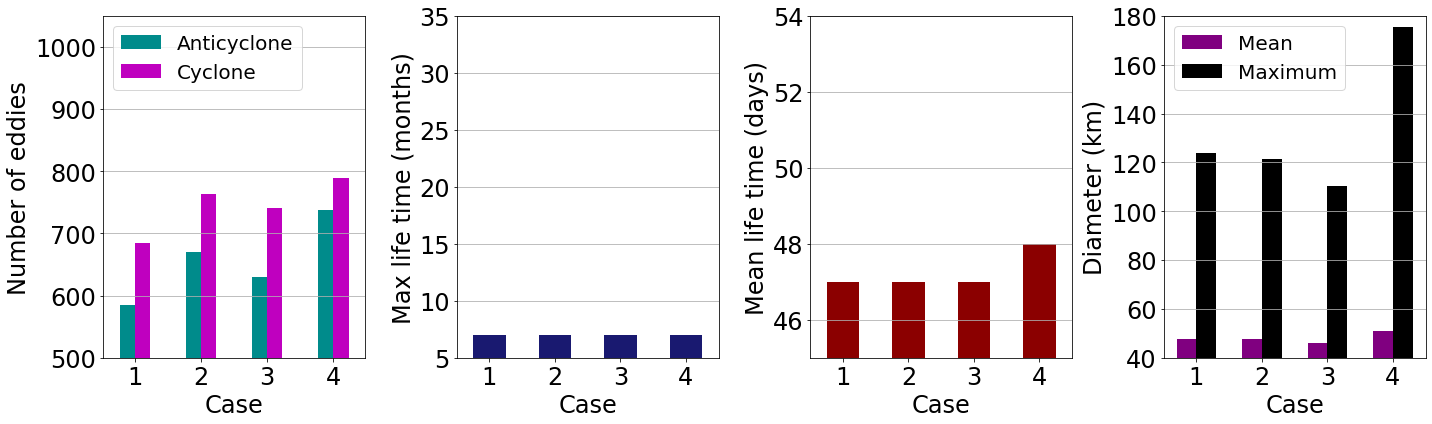

In [95]:
fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=4)

eddy_stat_d.groupby(eddy_stat_d.case).type.value_counts().unstack(1).plot.bar(ax=ax[0], color={'darkcyan', 'm'}, width=0.46, rot=0)
ax[0].legend(['Anticyclone', 'Cyclone'], fontsize=20, loc='upper left')
ax[0].set_ylabel('Number of eddies', fontsize=24)
ax[0].set_ylim(bottom=500, top=1050)

# lim=ax[0].get_xlim()
# ant = eddy_stat_d.loc[eddy_stat_d.type == 'anticyclonic']
# cyc = eddy_stat_d.loc[eddy_stat_d.type == 'cyclonic']

eddy_stat_d.groupby(eddy_stat_d.case).life_time.max().astype('timedelta64[M]').plot.bar(ax=ax[1], color='midnightblue', rot=0) #position=1 width=0.23
# ant.groupby(ant.case).life_time.max().astype('timedelta64[M]').plot.bar(ax=ax[1], color='red', position=1, width=0.23)
# cyc.groupby(cyc.case).life_time.max().astype('timedelta64[M]').plot.bar(ax=ax[1], color='midnightblue', position=0, width=0.23)

# ax2 = ax[1].twinx()
eddy_stat_d.groupby(eddy_stat_d.case).life_time.mean().astype('timedelta64[D]').plot.bar(ax=ax[2], color='darkred', rot=0)

# ant.groupby(ant.case).life_time.mean().astype('timedelta64[D]').plot.bar(ax=ax[2], color='darkred', position=1, width=0.23)
# cyc.groupby(cyc.case).life_time.mean().astype('timedelta64[D]').plot.bar(ax=ax[2], color='blue', position=0, width=0.23)

ax[1].set_ylim(bottom=5, top=35)
ax[2].set_ylim(bottom=45, top=54)
# ax[2].set_ylim(bottom=30, top=46)
ax[1].set_ylabel('Max life time (months)', fontsize=24)
ax[2].set_ylabel('Mean life time (days)', fontsize=24)
ax[1].tick_params(axis= 'y', labelsize= 24)
ax[2].tick_params(axis= 'y',labelsize= 24)

(2* eddy_stat_d.groupby(eddy_stat_d.case).scale_mean.mean()).plot.bar(ax=ax[3], position=1, width=0.3, color='purple', label= 'Mean', rot=0) #width=0.23
(2* eddy_stat_d.groupby(eddy_stat_d.case).scale_max.max()).plot.bar(ax=ax[3], position=0, width=0.3 ,color= 'k', label= 'Maximum', rot=0)
# (2* ant.groupby(ant.case).scale_mean.mean()).plot.bar(ax=ax[3], position=1, width=0.2, color='red', label= 'Mean') #width=0.23
# (2* ant.groupby(ant.case).scale_max.max()).plot.bar(ax=ax[3], position=0, width=0.2 ,color= 'darkred', label= 'Maximum')
# (2* cyc.groupby(cyc.case).scale_mean.mean()).plot.bar(ax=ax[3], position=2, width=0.2, color='blue', label= 'Mean') #width=0.23
# (2* cyc.groupby(cyc.case).scale_max.max()).plot.bar(ax=ax[3], position=3, width=0.2 ,color= 'midnightblue', label= 'Maximum')

# ax[3].set_xlim(lim)
ax[3].set_ylabel('Diameter (km)', fontsize=24)
# ax[3].tick_params(axis= 'y', labelsize= 24)
# ax[3].tick_params(axis= 'x', labelsize= 24)
ax[3].set_ylim(bottom=40, top=180)
plt.xticks([0,1,2,3,4,5,6,7]) #workaround for position of bars
ax[3].set_xlim(-0.5,3.5)

# eddy_stat.groupby(eddy_stat.index).life_time.mean().astype('timedelta64[D]').plot.bar(ax=ax, color='red', stacked='False')

ax[3].legend(loc='upper left', fontsize=20)


for axs in ax:
    axs.set_xlabel('Case', fontsize=24)
    axs.grid(axis='y')
    axs.tick_params(axis= 'x', labelsize= 24)
    axs.tick_params(axis= 'y', labelsize= 24)


plt.tight_layout()

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
plt.savefig(save_path + 'stats_drake_220227.png', format='png', facecolor="w",  bbox_inches='tight')

In [28]:
eddy_stat_r4.groupby('case')

In [26]:
eddy_stat_r4

,time,amp,area,scale,type,exist_at_start,terminated,case,life_time,area_mean,area_max,scale_mean,scale_max
155,"[1970-01-18T12:00:00.000000000, 1970-01-23T12:...","[2.906622512243848e-06, 7.181013186413419e-06,...","[2647.496020877659, 3092.716690014198, 2222.76...","[29.029711625808588, 31.375823456877256, 26.59...",cyclonic,False,True,2,40 days,1756.511123,3092.716690,23.204142,31.375823
156,"[1970-01-18T12:00:00.000000000, 1970-01-23T12:...","[5.053776230747145e-06, 2.517681134364658e-06,...","[2021.094194289107, 1846.2004332989004, 2096.6...","[25.364034831841835, 24.241779014664704, 25.83...",anticyclonic,False,True,2,40 days,2051.984774,3154.632943,25.298371,31.688339
158,"[1970-01-18T12:00:00.000000000, 1970-01-23T12:...","[7.018853049598676e-06, 7.722894601036487e-06,...","[1194.177798892753, 943.3664701595052, 1127.07...","[19.49663045884498, 17.32867201334472, 18.9409...",cyclonic,False,True,2,35 days,946.833430,1194.177799,17.204066,19.496630
160,"[1970-01-18T12:00:00.000000000, 1970-01-23T12:...","[3.827161147410461e-06, 4.406067160249604e-06,...","[885.3071627663114, 740.7077399210593, 706.132...","[16.786959886109194, 15.354953480545788, 14.99...",anticyclonic,False,True,2,35 days,952.309379,1263.131036,17.327793,20.051611
163,"[1970-01-18T12:00:00.000000000, 1970-01-23T12:...","[5.863600119128413e-06, 6.123035323842753e-06,...","[5657.464849489944, 4920.08881014645, 3441.438...","[42.43615195007602, 39.574144452809826, 33.097...",anticyclonic,False,True,2,30 days,4161.923023,5657.464849,36.256646,42.436152
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10571,"[1974-11-19T12:00:00.000000000, 1974-11-24T12:...","[3.3971734928627135e-06, 9.373882552466307e-06...","[1180.254636557173, 1645.3723159032822, 1491.6...","[19.382639630102112, 22.88532880701376, 21.790...",anticyclonic,False,True,8,30 days,1308.138534,1645.372316,20.335227,22.885329
10582,"[1974-11-19T12:00:00.000000000, 1974-11-24T12:...","[1.2551875743878677e-05, 2.1244386632043437e-0...","[3045.120774636618, 3385.0122724623907, 3303.4...","[31.133455432869614, 32.82503421442601, 32.427...",cyclonic,False,True,8,35 days,3431.392361,4797.566754,32.843700,39.078292
10609,"[1974-11-19T12:00:00.000000000, 1974-11-24T12:...","[5.7940590348030935e-06, 4.716334967531283e-06...","[5613.786608150094, 7828.718469359354, 6489.15...","[42.2720211996108, 49.919520079290784, 45.4484...",anticyclonic,False,True,8,35 days,4350.967250,7828.718469,35.830238,49.919520
10614,"[1974-11-24T12:00:00.000000000, 1974-11-29T12:...","[6.804283332949709e-06, 7.597004226742564e-06,...","[1294.8761175998943, 1015.7784651038168, 1294....","[20.302016392844607, 17.98144398025758, 20.295...",anticyclonic,False,True,8,30 days,1144.559532,1294.876118,19.047576,20.302016


In [23]:
# selecting eddies that start and terminate within the time period
eddy_stat_r4 = eddy_stat_r4.loc[(eddy_stat_r4['exist_at_start'] ==  False) & (eddy_stat_r4.terminated == True) 
                          & (eddy_stat_r4.life_time >= timedelta(days=30))]

In [40]:
eddy_stat = eddy_stat_r4

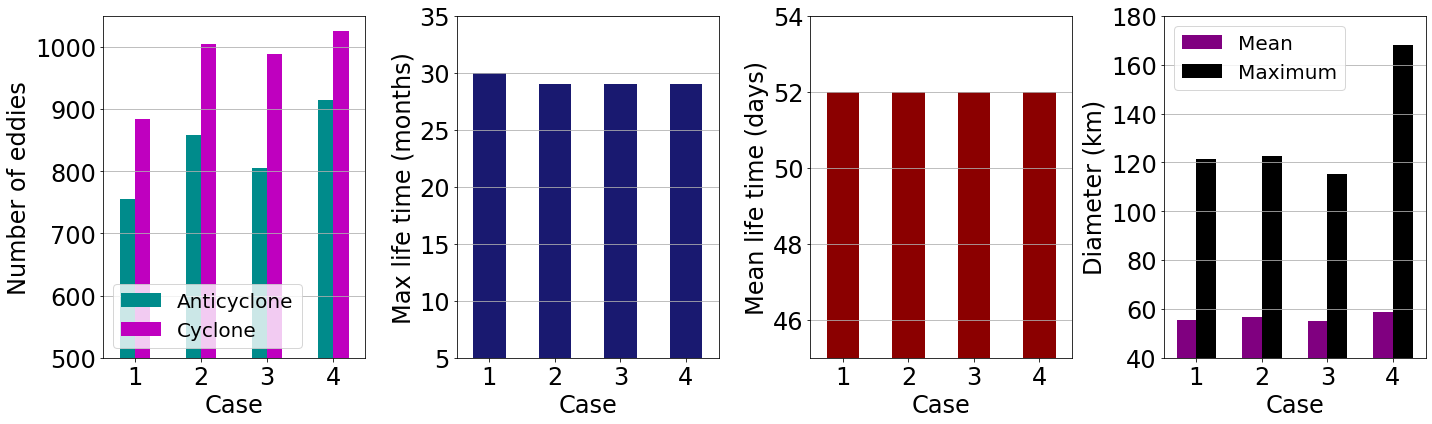

In [96]:
fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=4)

eddy_stat.groupby(eddy_stat.case).type.value_counts().unstack(1).plot.bar(ax=ax[0], color={'darkcyan', 'm'}, width=0.46, rot=0)
ax[0].legend(['Anticyclone', 'Cyclone'], fontsize=20, loc='lower left')
ax[0].set_ylabel('Number of eddies', fontsize=24)
ax[0].set_ylim(bottom=500, top=1050)

# lim=ax[0].get_xlim()
eddy_stat.groupby(eddy_stat.case).life_time.max().astype('timedelta64[M]').plot.bar(ax=ax[1], color='midnightblue', rot=0)
# ax2 = ax[1].twinx()
eddy_stat.groupby(eddy_stat.case).life_time.mean().astype('timedelta64[D]').plot.bar(ax=ax[2], color='darkred', rot=0)
# ax[2].set_xlim(lim)
ax[2].set_ylim(bottom=45, top=54)
ax[1].set_ylim(bottom=5, top=35)
ax[1].set_ylabel('Max life time (months)', fontsize=24)
ax[2].set_ylabel('Mean life time (days)', fontsize=24)
ax[1].tick_params(axis= 'y', labelsize= 24)
ax[2].tick_params(axis= 'y', labelsize= 24)

(2*eddy_stat.groupby(eddy_stat.case).scale_mean.mean()).plot.bar(ax=ax[3], position=1, width=0.3, color='purple', label= 'Mean', rot=0)
(2*eddy_stat.groupby(eddy_stat.case).scale_max.max()).plot.bar(ax=ax[3], position=0, width=0.3 ,color= 'k', label= 'Maximum', rot=0)
# ax[3].set_xlim(0,5)
ax[3].set_ylabel('Diameter (km)', fontsize=24)
ax[3].set_ylim(bottom=40, top=180)
plt.xticks([0,1,2,3,4,5,6,7]) #workaround for position of bars
ax[3].set_xlim(-0.5,3.5)

# eddy_stat.groupby(eddy_stat.index).life_time.mean().astype('timedelta64[D]').plot.bar(ax=ax, color='red', stacked='False')

# ax[0].grid(axis='y')
# ax[2].grid(axis='y')
# ax2.grid()

ax[3].legend(loc='upper left', fontsize=20)

# plt.suptitle('Region 4', fontsize= 18)

for axs in ax:
    axs.set_xlabel('Case', fontsize=24)
    axs.grid(axis='y')
    axs.tick_params(axis= 'x', labelsize= 24)
    axs.tick_params(axis= 'y', labelsize= 24)

plt.tight_layout()
    
    
save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/sensitivity/applied_mask/'
plt.savefig(save_path + 'stats_region4_220227.png', format='png', facecolor="w",  bbox_inches='tight')

In [64]:
    'center': Center the base on the x positions.

    'edge': Align the left edges of the bars with the x positions.

To align the bars on the right edge pass a negative width and align='edge'.

Object `ax.set_xlim` not found.


In [ ]:
ax[3].set_xlim

In [ ]:
eddy_stat.groupby(eddy_stat.case).scale_mean.mean().plot.bar

In [ ]:
eddy_stat.groupby(eddy_stat.case).scale_mean.mean().plot

In [ ]:
# a = pd.concat(
#     [eddy_stat.groupby(eddy_stat.case).life_time.max().astype('timedelta64[D]').rename('max'), 
#      eddy_stat.groupby(eddy_stat.case).life_time.mean().astype('timedelta64[D]').rename('mean')], axis=1).reset_index()

In [ ]:
tracks[0]

#### plotting

### Interpolate mask for sampling

In [ ]:
data = data.isel(x_c=slice(1,-1), x_r=slice(1,-1), y_r=slice(1,-1), y_c=slice(1,-1))

In [ ]:
mask_2d = xr.open_dataset(datapath + 'mask/' +'mask_nest_int_2d.nc')

In [ ]:
mask_2d = mask_2d.rename_dims({'y':'y_c', 'x':'x_c'})

In [ ]:
mask_2d = mask_2d.reset_coords(['nav_lon', 'nav_lat'], drop=True)

In [ ]:
mask_2d = mask_2d.assign_coords({'y_c': data.coords['y_c'],
                                 'x_c': data.coords['x_c']})

In [ ]:
data = data.update({'mask_regions': mask_2d.mask_nest})

In [ ]:
data

In [ ]:
# INTERPOLATION
# Define the parameters for the interpolation -- CONSIDER THE DISOCNTINUITY IN THE LONGITUDE
interpolation_parameters = {'model': 'ORCA',
                            'grid': 'latlon',
                            'start_time': YEAR + '-01-01', # time range start
                            'end_time': YEAR + '-12-31', # time range end
                            'calendar': 'standard', # calendar, must be either 360_day or standard
                            'lon1': 77.5, # minimum longitude of detection region
                            'lon2': 69.5,  # maximum longitude
                            'lat1': -65, # minimum latitude
                            'lat2': -37, # maximum latitude
                            'res': 1./10., # resolution of the fields in degrees
                            'vars_to_interpolate': ['somxl010'], # variables to be interpolated 
                            'mask_to_interpolate': ['fmask', 'tmask', 'bathymetry', 'mask_regions']} # masks to interpolate

# The OW parameter and vorticity just need to be extracted at the depth level at which we want
# to detect eddies. In this case we chose level 9
data_int_try = et.interp.horizontal(data.isel(z_c=0, z_l=0), metrics2D, interpolation_parameters)

In [ ]:
data_int_try = data_int_try.chunk({'lon': 3561, 'lat': 501})
with ProgressBar():
    data_int_try.to_netcdf(datapath + 'interpolated/' + 'int_mask_regions.nc')

In [ ]:
data_int

## Sampling

Things to note for the setting of `sample_parameters`:  
1. `'start_time'` is required to be no earlier than the earliest actual date of the tracked eddies. In our case here, for the year 2018 and a 5-day temporal resolution of the data, this is `'2018-01-03'` (if we had daily data, it would be `'2018-01-01'`).
2. `'lon1'` and `'lon2'` need to be identical to `'lon1'` and `'lon2'` in `detection_parameters`.  
3. Right now, the usage of `'range'` and `'split'` has not been thouroughly tested! It seems to work for most cases though.  

`'range'`: Set to `True` if you only want to sample eddies within a certain range `'values_range'` of a property `'var_range'` in the dataset `'ds_range'`. `'var_range'` needs to be 2D (thus the `.isel(z=9)` in the example below) and interpolated to the same grid as `OW` used above. It is most likely that, if you follow this example, `'var_range'` is stored in the same dataset as `OW`. In the example below, only eddies that have a center temperature between 4 and 7 degrees C at depth level 10 (`z=9`) will be sampled and stored.  

`'split'`: Set to `True` if you want to split the sampled eddies into two categories, above and below a certain threshold value `'value_split'` of a variable `'var_split'` in the dataset `'ds_split'`. As for `'range'`, `'var_split'` needs to be 2D and interpolated to the same grid as `OW` used above. In the example below the eddies will be put into two categories: In the first category, the eddies must have a center surface salinity above 34.0 and in the second category, below 34.0.

### Drake Passage - Case 2

In [29]:
del tracks

In [15]:
datapath = '/scratch/usr/shkifmmp/master/data/ORION10/'

In [30]:
# This is how to open the tracks-file again (no need to do that if we just saved it)
# with open(datapath + 'eddies_detect/acc/'
with open('/scratch/usr/shkifmmp/master/data/ORION10/eddies_detect/acc/'
          + 'case9_20010101_20011231_tracks_OW0.3_77.5_69.5.pickle', 'rb') as f:
    tracks = pickle.load(f)
f.close()

In [31]:
tracks[0]

{'time': array(['2001-01-03T12:00:00.000000000', '2001-01-08T12:00:00.000000000',
        '2001-01-13T12:00:00.000000000', '2001-01-18T12:00:00.000000000',
        '2001-01-23T12:00:00.000000000', '2001-01-28T12:00:00.000000000'],
       dtype='datetime64[ns]'),
 'lon': array([-98.5959816 , -98.63117367, -98.89308455, -98.87058017,
        -98.73443729, -98.60170131]),
 'lat': array([-64.58595043, -64.58990309, -64.59291979, -64.65429392,
        -64.76516292, -64.88235544]),
 'amp': array([2.21997553e-06, 3.06692336e-06, 3.04789824e-06, 2.49198796e-06,
        1.91020314e-06, 1.24985417e-06]),
 'eddy_j': {0: array([26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28,
         28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
         29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30,
         30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31,
         31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,


In [37]:
data_int_t

<xarray.Dataset>
Dimensions:       (time: 73, z: 46, lat: 501, lon: 3561)
Coordinates:
  * time          (time) datetime64[ns] 2001-01-03T12:00:00 ... 2001-12-29T12...
  * z             (z) int64 1 2 3 4 5 6 7 8 9 10 ... 38 39 40 41 42 43 44 45 46
  * lat           (lat) float32 -65.97 -65.93 -65.89 ... -36.18 -36.09 -36.01
  * lon           (lon) float32 75.5 75.6 75.7 75.8 75.9 ... 71.2 71.3 71.4 71.5
Data variables:
    votemper      (time, z, lat, lon) float64 dask.array<chunksize=(73, 46, 501, 3561), meta=np.ndarray>
    vosaline      (time, z, lat, lon) float64 dask.array<chunksize=(73, 46, 501, 3561), meta=np.ndarray>
    fmask         (z, lat, lon) float64 dask.array<chunksize=(46, 501, 3561), meta=np.ndarray>
    tmask         (z, lat, lon) float64 dask.array<chunksize=(46, 501, 3561), meta=np.ndarray>
    e1f           (lat, lon) float64 dask.array<chunksize=(501, 3561), meta=np.ndarray>
    e2f           (lat, lon) float64 dask.array<chunksize=(501, 3561), meta=np.ndarray>
    OW            (time, lat, lon) float64 dask.array<chunksize=(73, 501, 3561), meta=np.ndarray>
    vort          (time, lat, lon) float64 dask.array<chunksize=(73, 501, 3561), meta=np.ndarray>
    bathymetry    (lat, lon) float64 dask.array<chunksize=(501, 3561), meta=np.ndarray>
    OW_std        (lat, lon) float64 dask.array<chunksize=(501, 3561), meta=np.ndarray>
    mask_regions  (time, lat, lon) float64 dask.array<chunksize=(73, 501, 3561), meta=np.ndarray>
    sohefldo      (time, lat, lon) float64 dask.array<chunksize=(73, 501, 3561), meta=np.ndarray>
Attributes:
    NCO:                        netCDF Operators version 4.9.1 (Homepage = ht...
    history:                    Tue Feb 22 12:54:07 2022: /sw/dataformats/nco...
    history_of_appended_files:  Tue Feb 22 12:54:07 2022: Appended file int_d...

In [38]:
datapath /scratch/usr/shkifmmp/master/data/ORION10/eddies_detect/acc/

'/scratch/usr/shkifmmp/master/data/ORION10/'

In [39]:
# For the sampling we again have to specify some parameters, defining when, where and which 
# eddies to sample.
# Because the dataset containing the sampled eddies can grow huge for larger regions and/or
# longer time periods, `eddytools.sample.sample()` writes the samples for each individual
# eddy to individual netcdf-files on disk!
sample_parameters = {'model': 'ORCA',
                     'grid': 'latlon',
                     'start_time': '2001-01-03', # time range start
                     'end_time': '2001-12-31', # time range end
                     'calendar': 'standard', # calendar, must be either 360_day or standard
                     'max_time': 73, # maximum length of tracks to consider
                                     # (model time steps)
                     'lon1': 77.5, # minimum longitude of detection region
                     'lon2': 69.5, # maximum longitude
#                      'lon1': -76,
#                      'lon2': -50,
                     'lat1': -65, # minimum latitude
                     'lat2': -37, # maximum latitude
                     'type': 'anticyclonic', # type of eddy
                     'lifetime': 10, # min length of the eddy's track in days
                     'size': 20, # eddy size (diameter in km)
                     'd_surr': 1,
                     'range': False, # sample eddy within a range of `var_range`
                     'ds_range': data_int, # dataset of `var_range`
                     'var_range': ['mask_regions_2'], # variable to base the range on
                     'value_range': [[9,11],], # range of `var_range`
                     'split': False, # split eddies at a threshold in below and above
                     'ds_split': data_int.isel(z=0), # dataset of `var_split`
                     'var_split': ['vosaline'], # variable to base split on
                     'value_split': [34.0,], # split eddies at this value
                     'sample_vars': ['votemper'], # variables to sample
                     'save_location': datapath + 'eddies_detect/acc/', # where to store the netcdf files 
                     'save_name': 'samples_test_acc'}

In [40]:
et.sample.sample(tracks, data_int_t, sample_parameters)

data prepared, now sampling
sampling eddy number 0 of 22690
sampling eddy number 2521 of 22690
sampling eddy number 5042 of 22690
sampling eddy number 7563 of 22690
sampling eddy number 10084 of 22690
sampling eddy number 12606 of 22690
sampling eddy number 15127 of 22690
sampling eddy number 17648 of 22690
sampling eddy number 20169 of 22690


### Averaging

In [35]:
samples = {}
num_samples = len(glob(sample_parameters['save_location']
                       + sample_parameters['save_name'] + '.cyclonic.larger_20.longer_10.*.nc'))

In [36]:
num_samples

0

In [22]:
# Now we load each stored sample
for i in np.arange(1, num_samples + 1):
    snum = "%07d" % (i,)
    samples[i] = xr.open_dataset(sample_parameters['save_location'] + sample_parameters['save_name'] +
                                 '.cyclonic.larger_40.longer_30.' + str(snum) + '.nc', chunks={})

In [26]:
normalized_eddies = et.average.prepare(samples, ['votemper'], interp_vec=50)

votemper


In [41]:
[*season_eddies['ave']['mean']['JJA']['votemper_around'].keys()]

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [42]:
season_eddies['ave']['mean']['JJA']['votemper_around']

array([3.50692746, 3.51120087, 3.51649956, 3.52132192, 3.52526187,
       3.52594515, 3.52264342, 3.51361577, 3.49396261, 3.43679853,
       3.35979082, 3.2799249 , 3.21101338, 3.15209879, 3.11183004,
       3.07982719, 3.07644799, 3.03446017, 2.93776703, 2.80859417,
       2.68109118, 2.56313589, 2.45184112, 2.35148798, 2.2430673 ,
       2.1230194 , 1.97359945, 1.80164038, 1.61328004, 1.42110569,
       1.24333115, 1.08337496, 0.94709263, 0.83102995, 0.73134473,
       0.6419867 , 0.56156294, 0.49099784, 0.43833357, 0.37927782,
       0.32413531, 0.31842009, 0.27166813, 0.18939567, 0.34422201,
              nan])

In [27]:
season_eddies = et.average.seasonal(normalized_eddies, ['votemper'])

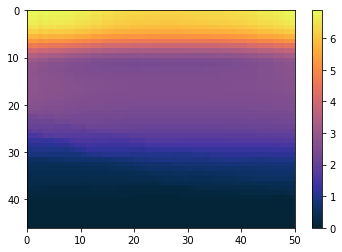

In [44]:
fig, axs = plt.subplots()

map1 = axs.pcolormesh(season_eddies['ave']['mean']['DJF']['votemper'], cmap=cm.thermal) #, vmin=-1, vmax=1
plt.colorbar(map1)
axs.invert_yaxis()

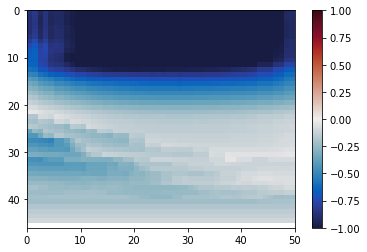

In [33]:
fig, axs = plt.subplots()

map1 = axs.pcolormesh(season_eddies['ave']['mean']['DJF']['votemper_anom'], vmin=-1, vmax=1, cmap=cm.balance) #, vmin=-1, vmax=1
plt.colorbar(map1)
axs.invert_yaxis()